In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
from more_itertools import set_partitions
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
dict_genres = {'Blues':0, 'Classical':1, 'Country':2, 'Disco':3, 'Hip-Hop':4, 'Jazz':5, 'Metal':6, 'Pop':7, 'Reggae':8, 'Rock':9}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'Disco', 4: 'Hip-Hop', 5: 'Jazz', 6: 'Metal', 7: 'Pop', 8: 'Reggae', 9: 'Rock'}


In [4]:
npzfile = np.load('data/all_targets_sets_train_new.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(7990, 128, 128) (7990, 10)


In [5]:
npzfile = np.load('data/all_targets_sets_valid_new.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(1000, 128, 128) (1000, 10)


## Check by plotting a Spectogram

Disco
(128, 128)


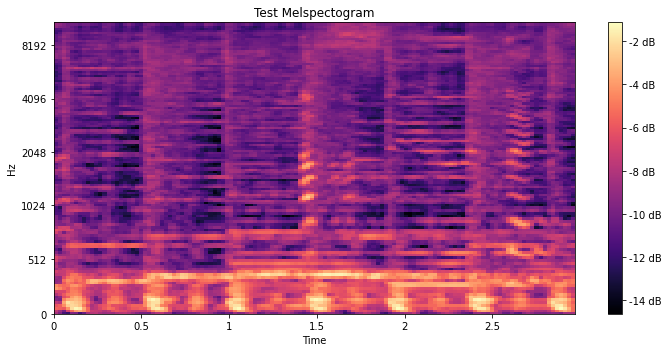

In [6]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
print(spectogram.shape)
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [7]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [8]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model

In [9]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 128
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_9/model_root/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_9/model_root/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [10]:
def create_split(elem):
    splits = list(set_partitions(elem, 2))
    _splits = []
    for i in range(len(splits)):
        try:
            if len(splits[i][0]) != 1 and len(splits[i][1]) != 1 and len(splits[i][0]) != 2 and len(splits[i][1]) != 2 and len(splits[i][0]) != 3 and len(splits[i][1]) != 3 and len(splits[i][0]) != 4 and len(splits[i][1]) != 4:
                _splits.append(splits[i])
        except:
            continue
    
    return _splits, len(_splits)

In [11]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Num splits 126
Folder num 1
Genre split [['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop'], ['Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None,

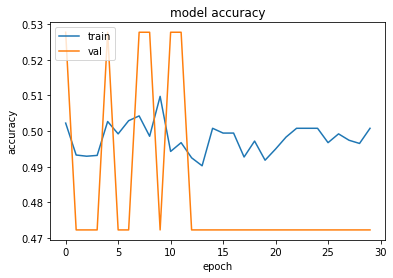

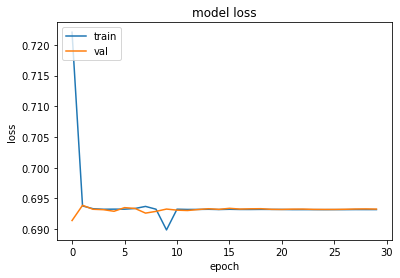

Folder num 2
Genre split [['Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz'], ['Blues', 'Metal', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

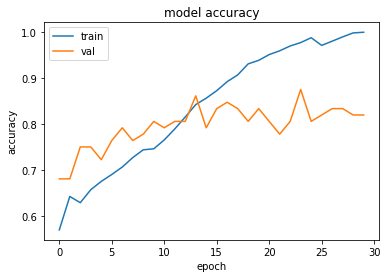

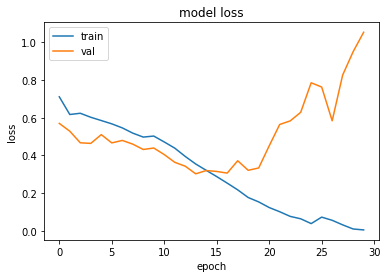

Folder num 3
Genre split [['Blues', 'Country', 'Disco', 'Hip-Hop', 'Jazz'], ['Classical', 'Metal', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

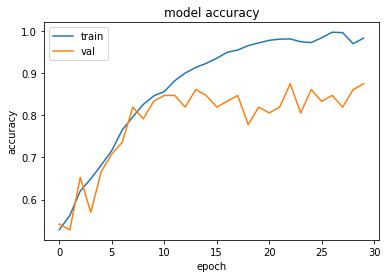

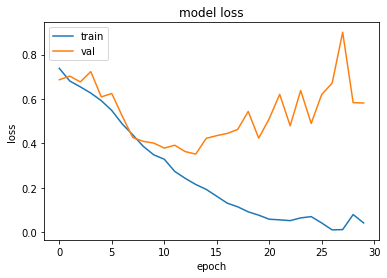

Folder num 4
Genre split [['Blues', 'Classical', 'Disco', 'Hip-Hop', 'Jazz'], ['Country', 'Metal', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

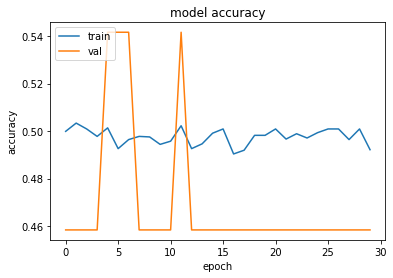

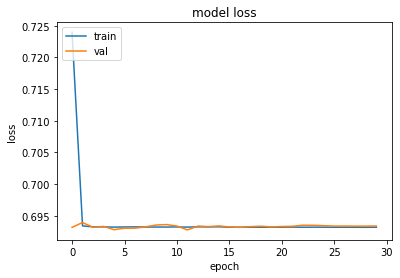

Folder num 5
Genre split [['Blues', 'Classical', 'Country', 'Hip-Hop', 'Jazz'], ['Disco', 'Metal', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

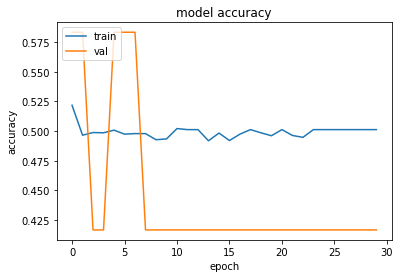

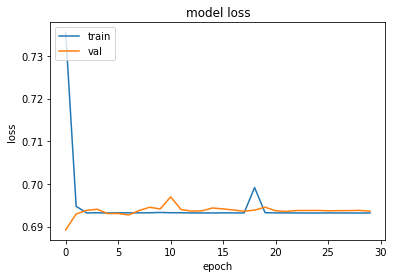

Folder num 6
Genre split [['Blues', 'Classical', 'Country', 'Disco', 'Jazz'], ['Hip-Hop', 'Metal', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

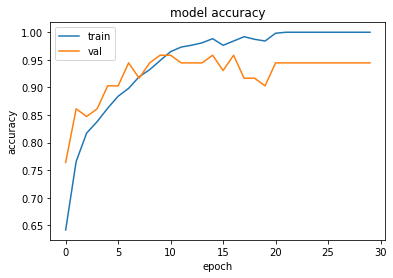

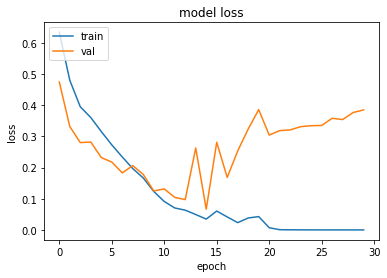

Folder num 7
Genre split [['Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal'], ['Blues', 'Classical', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

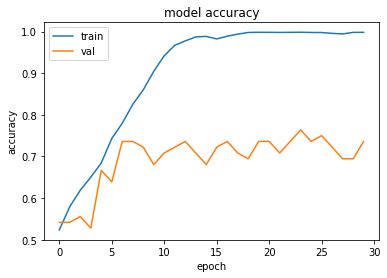

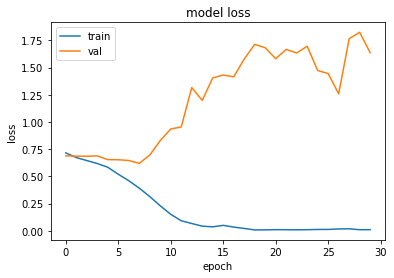

Folder num 8
Genre split [['Classical', 'Disco', 'Hip-Hop', 'Jazz', 'Metal'], ['Blues', 'Country', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

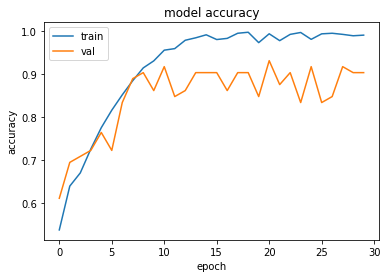

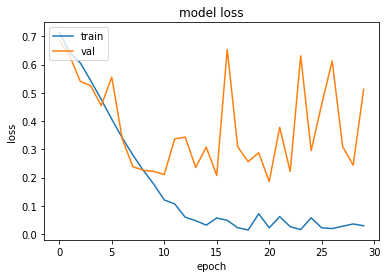

Folder num 9
Genre split [['Blues', 'Disco', 'Hip-Hop', 'Jazz', 'Metal'], ['Classical', 'Country', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128)

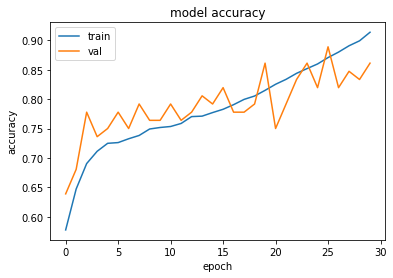

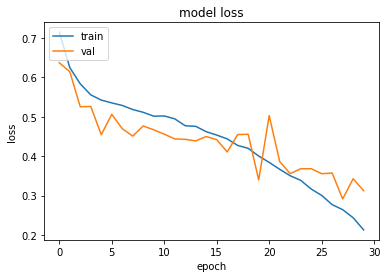

Folder num 10
Genre split [['Classical', 'Country', 'Hip-Hop', 'Jazz', 'Metal'], ['Blues', 'Disco', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 128

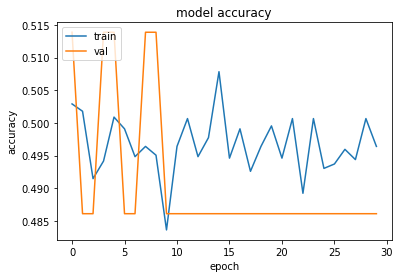

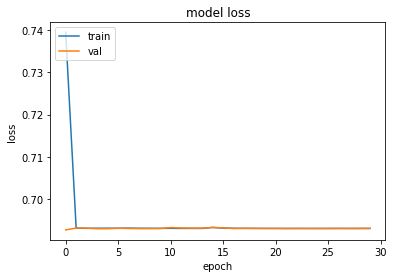

Folder num 11
Genre split [['Blues', 'Country', 'Hip-Hop', 'Jazz', 'Metal'], ['Classical', 'Disco', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

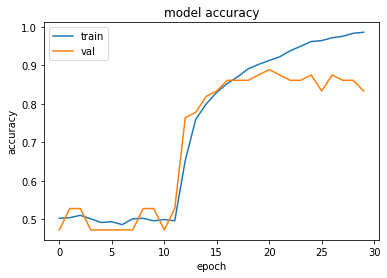

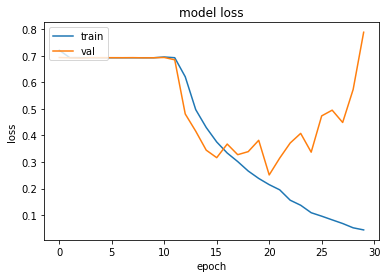

Folder num 12
Genre split [['Blues', 'Classical', 'Hip-Hop', 'Jazz', 'Metal'], ['Country', 'Disco', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

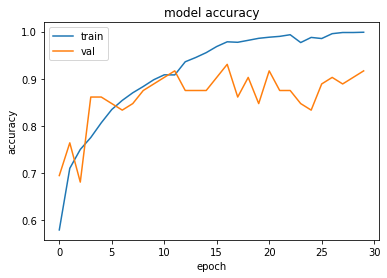

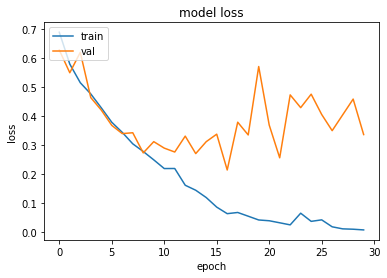

Folder num 13
Genre split [['Classical', 'Country', 'Disco', 'Jazz', 'Metal'], ['Blues', 'Hip-Hop', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

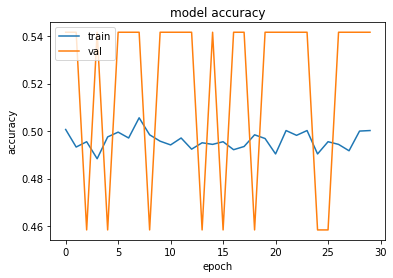

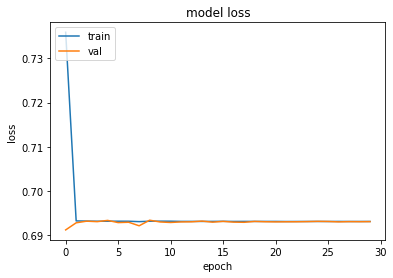

Folder num 14
Genre split [['Blues', 'Country', 'Disco', 'Jazz', 'Metal'], ['Classical', 'Hip-Hop', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

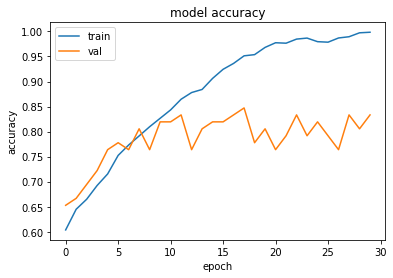

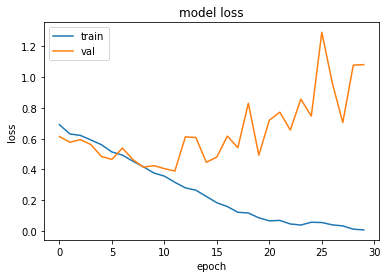

Folder num 15
Genre split [['Blues', 'Classical', 'Disco', 'Jazz', 'Metal'], ['Country', 'Hip-Hop', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

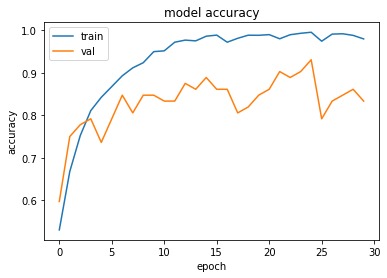

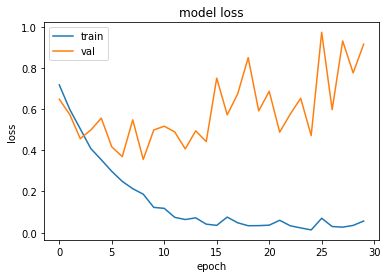

Folder num 16
Genre split [['Blues', 'Classical', 'Country', 'Jazz', 'Metal'], ['Disco', 'Hip-Hop', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

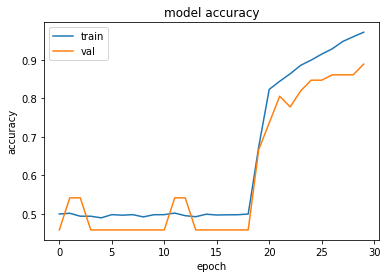

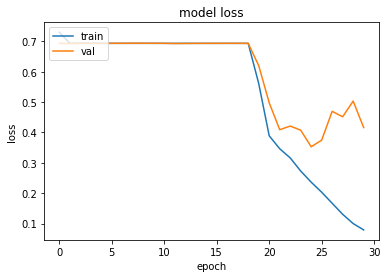

Folder num 17
Genre split [['Classical', 'Country', 'Disco', 'Hip-Hop', 'Metal'], ['Blues', 'Jazz', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

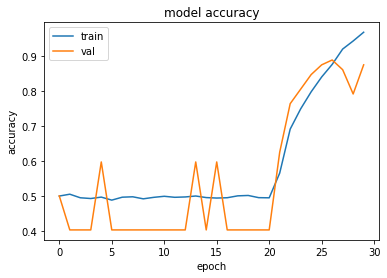

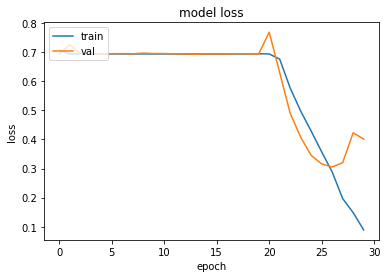

Folder num 18
Genre split [['Blues', 'Country', 'Disco', 'Hip-Hop', 'Metal'], ['Classical', 'Jazz', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

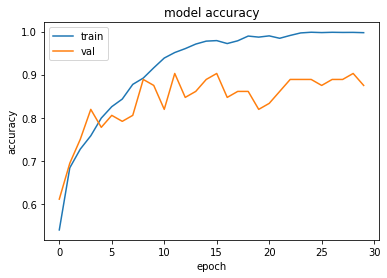

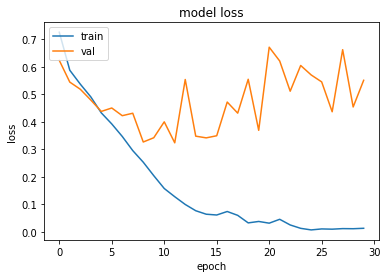

Folder num 19
Genre split [['Blues', 'Classical', 'Disco', 'Hip-Hop', 'Metal'], ['Country', 'Jazz', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

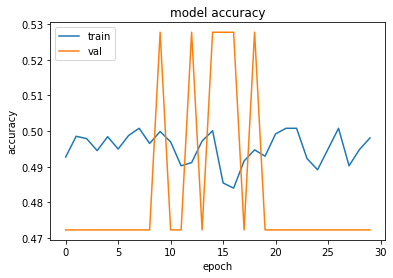

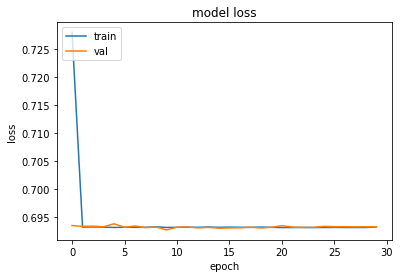

Folder num 20
Genre split [['Blues', 'Classical', 'Country', 'Hip-Hop', 'Metal'], ['Disco', 'Jazz', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

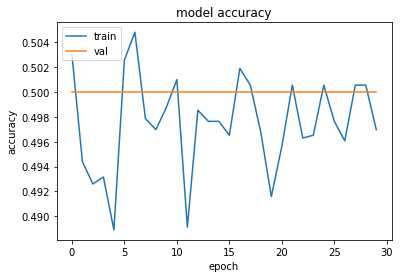

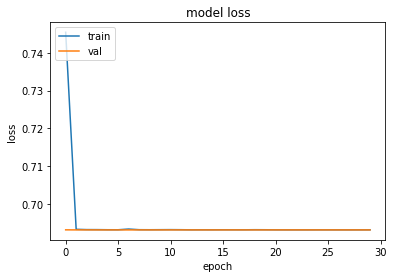

Folder num 21
Genre split [['Blues', 'Classical', 'Country', 'Disco', 'Metal'], ['Hip-Hop', 'Jazz', 'Pop', 'Reggae', 'Rock']]
Building model...
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

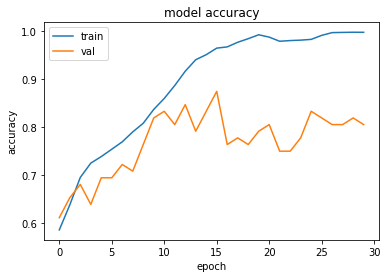

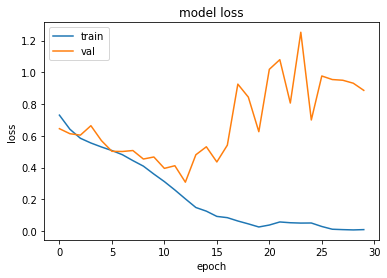

Folder num 22
Genre split [['Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop'], ['Blues', 'Classical', 'Country', 'Reggae', 'Rock']]
Building model...
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

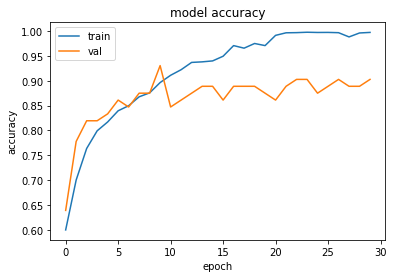

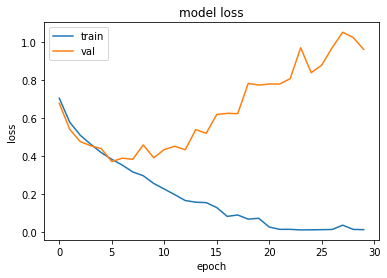

Folder num 23
Genre split [['Country', 'Hip-Hop', 'Jazz', 'Metal', 'Pop'], ['Blues', 'Classical', 'Disco', 'Reggae', 'Rock']]
Building model...
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

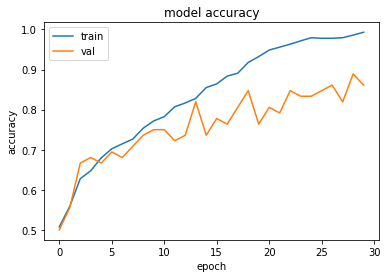

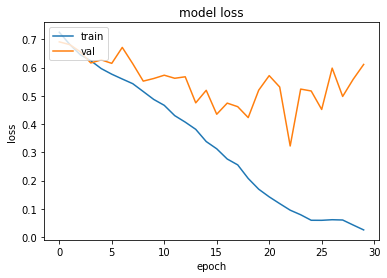

Folder num 24
Genre split [['Classical', 'Hip-Hop', 'Jazz', 'Metal', 'Pop'], ['Blues', 'Country', 'Disco', 'Reggae', 'Rock']]
Building model...
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

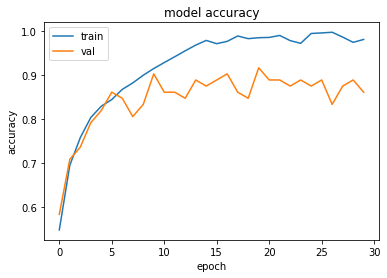

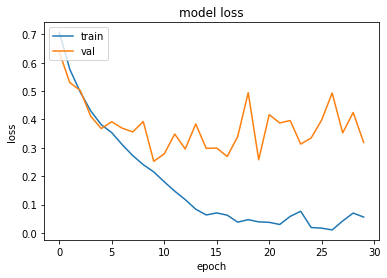

Folder num 25
Genre split [['Blues', 'Hip-Hop', 'Jazz', 'Metal', 'Pop'], ['Classical', 'Country', 'Disco', 'Reggae', 'Rock']]
Building model...
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

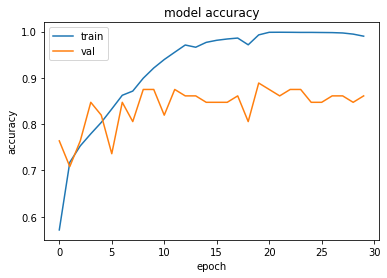

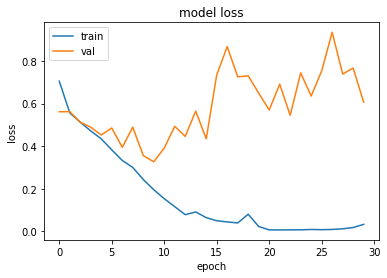

Folder num 26
Genre split [['Country', 'Disco', 'Jazz', 'Metal', 'Pop'], ['Blues', 'Classical', 'Hip-Hop', 'Reggae', 'Rock']]
Building model...
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

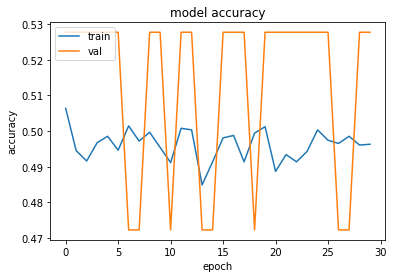

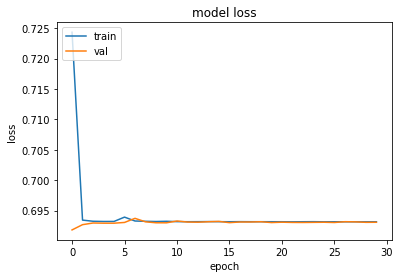

Folder num 27
Genre split [['Classical', 'Disco', 'Jazz', 'Metal', 'Pop'], ['Blues', 'Country', 'Hip-Hop', 'Reggae', 'Rock']]
Building model...
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

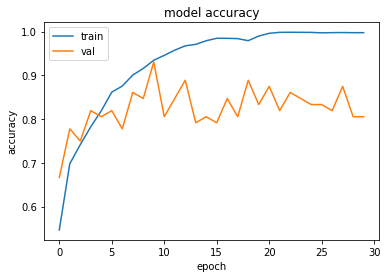

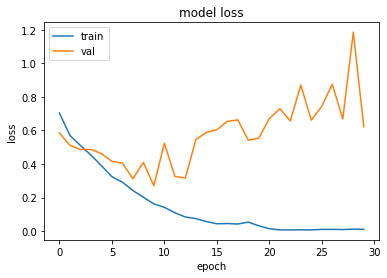

Folder num 28
Genre split [['Blues', 'Disco', 'Jazz', 'Metal', 'Pop'], ['Classical', 'Country', 'Hip-Hop', 'Reggae', 'Rock']]
Building model...
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

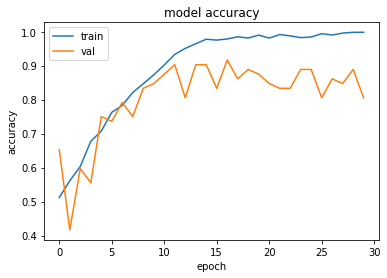

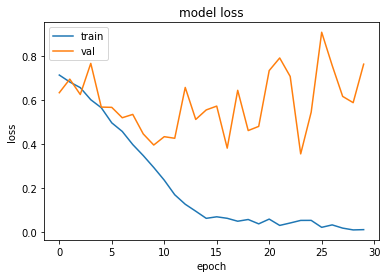

Folder num 29
Genre split [['Classical', 'Country', 'Jazz', 'Metal', 'Pop'], ['Blues', 'Disco', 'Hip-Hop', 'Reggae', 'Rock']]
Building model...
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

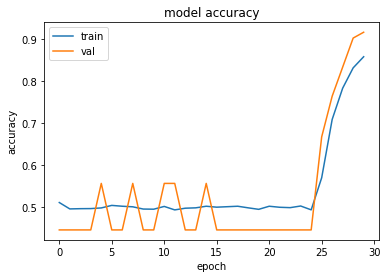

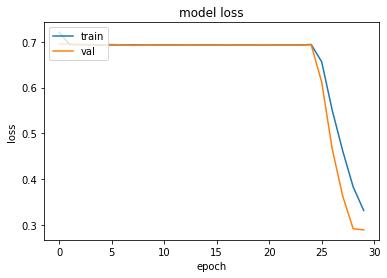

Folder num 30
Genre split [['Blues', 'Country', 'Jazz', 'Metal', 'Pop'], ['Classical', 'Disco', 'Hip-Hop', 'Reggae', 'Rock']]
Building model...
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

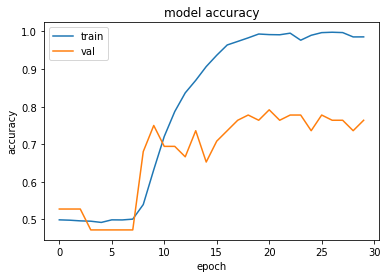

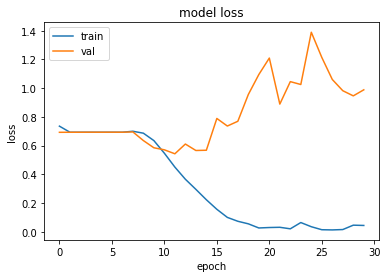

Folder num 31
Genre split [['Blues', 'Classical', 'Jazz', 'Metal', 'Pop'], ['Country', 'Disco', 'Hip-Hop', 'Reggae', 'Rock']]
Building model...
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

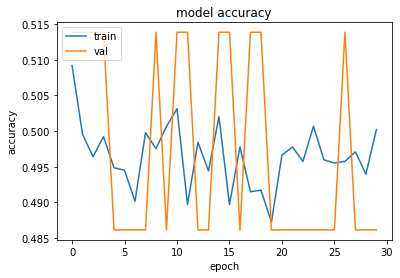

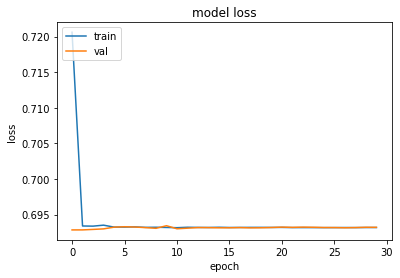

Folder num 32
Genre split [['Country', 'Disco', 'Hip-Hop', 'Metal', 'Pop'], ['Blues', 'Classical', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

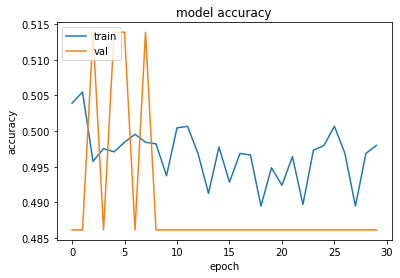

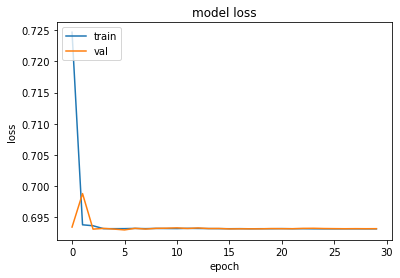

Folder num 33
Genre split [['Classical', 'Disco', 'Hip-Hop', 'Metal', 'Pop'], ['Blues', 'Country', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

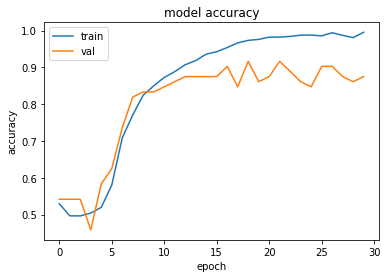

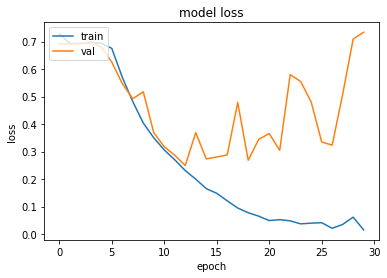

Folder num 34
Genre split [['Blues', 'Disco', 'Hip-Hop', 'Metal', 'Pop'], ['Classical', 'Country', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

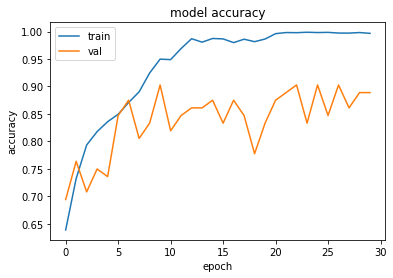

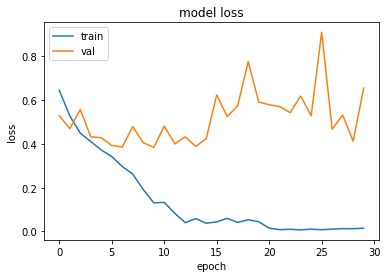

Folder num 35
Genre split [['Classical', 'Country', 'Hip-Hop', 'Metal', 'Pop'], ['Blues', 'Disco', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

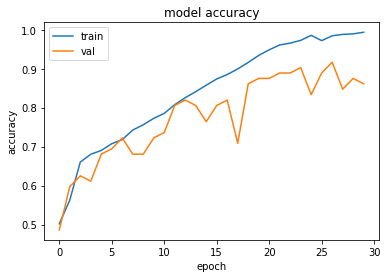

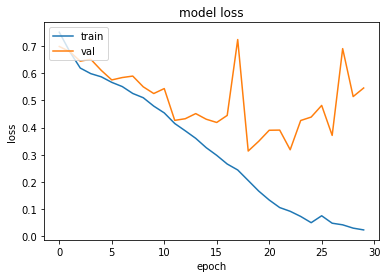

Folder num 36
Genre split [['Blues', 'Country', 'Hip-Hop', 'Metal', 'Pop'], ['Classical', 'Disco', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

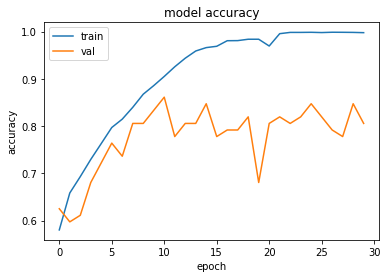

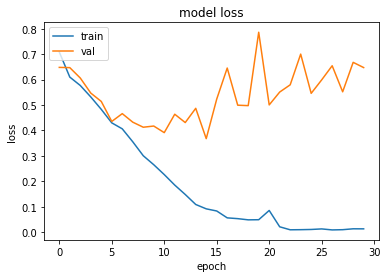

Folder num 37
Genre split [['Blues', 'Classical', 'Hip-Hop', 'Metal', 'Pop'], ['Country', 'Disco', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

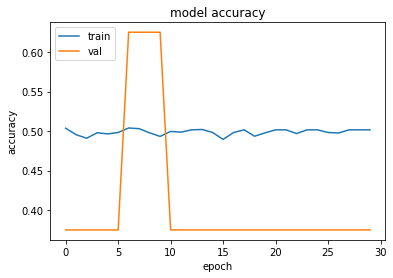

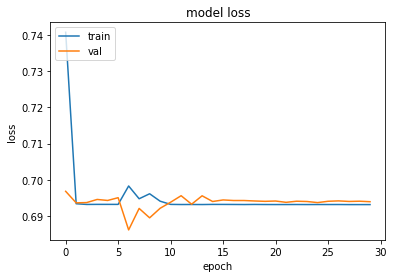

Folder num 38
Genre split [['Classical', 'Country', 'Disco', 'Metal', 'Pop'], ['Blues', 'Hip-Hop', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

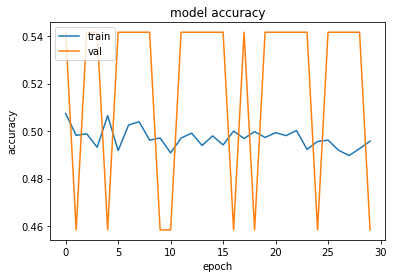

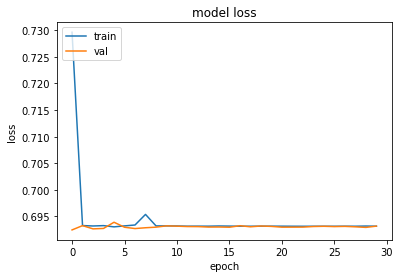

Folder num 39
Genre split [['Blues', 'Country', 'Disco', 'Metal', 'Pop'], ['Classical', 'Hip-Hop', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

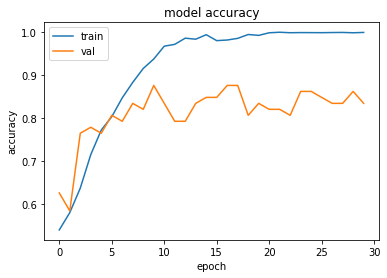

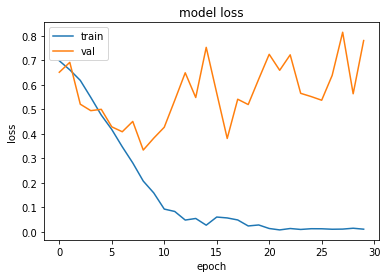

Folder num 40
Genre split [['Blues', 'Classical', 'Disco', 'Metal', 'Pop'], ['Country', 'Hip-Hop', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

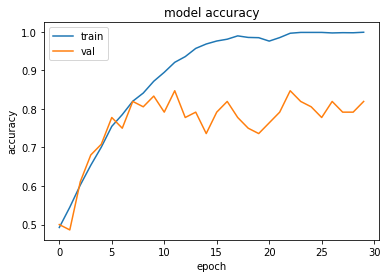

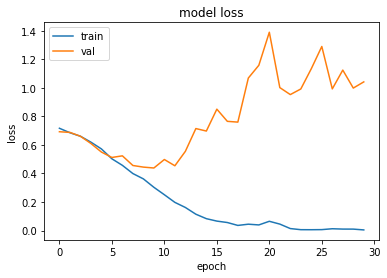

Folder num 41
Genre split [['Blues', 'Classical', 'Country', 'Metal', 'Pop'], ['Disco', 'Hip-Hop', 'Jazz', 'Reggae', 'Rock']]
Building model...
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

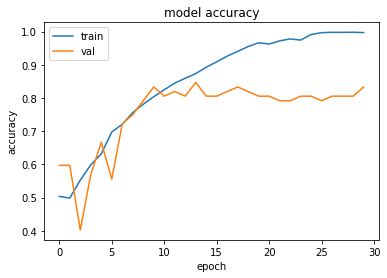

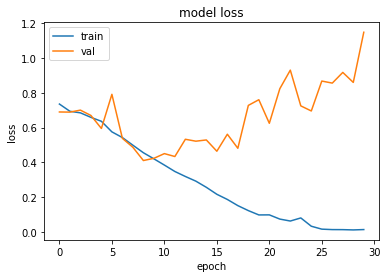

Folder num 42
Genre split [['Country', 'Disco', 'Hip-Hop', 'Jazz', 'Pop'], ['Blues', 'Classical', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

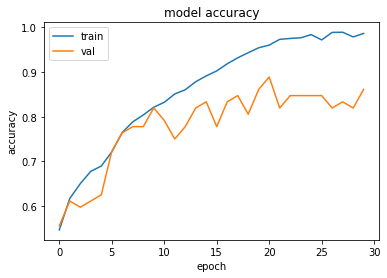

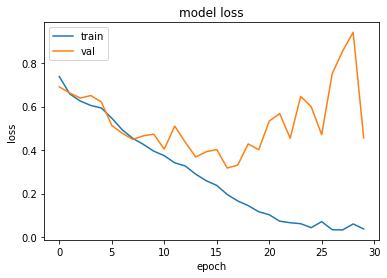

Folder num 43
Genre split [['Classical', 'Disco', 'Hip-Hop', 'Jazz', 'Pop'], ['Blues', 'Country', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

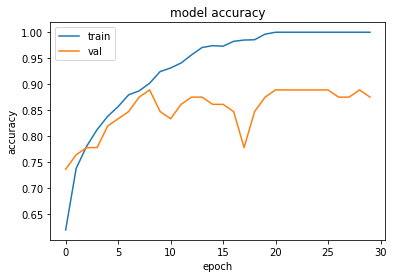

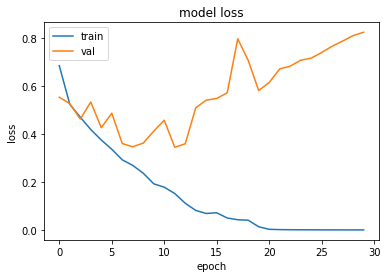

Folder num 44
Genre split [['Blues', 'Disco', 'Hip-Hop', 'Jazz', 'Pop'], ['Classical', 'Country', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

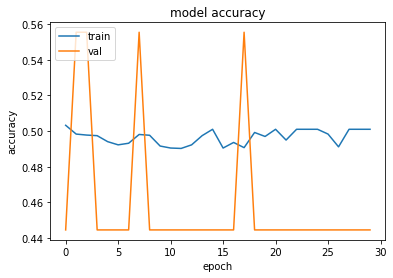

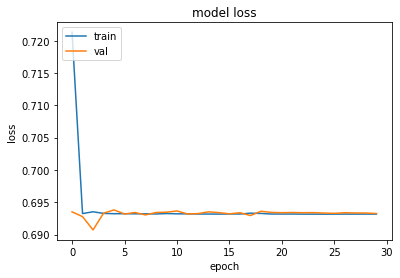

Folder num 45
Genre split [['Classical', 'Country', 'Hip-Hop', 'Jazz', 'Pop'], ['Blues', 'Disco', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_176 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_177 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

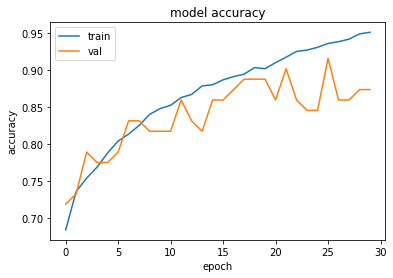

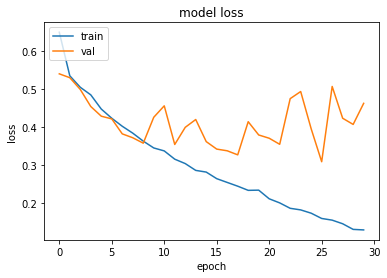

Folder num 46
Genre split [['Blues', 'Country', 'Hip-Hop', 'Jazz', 'Pop'], ['Classical', 'Disco', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

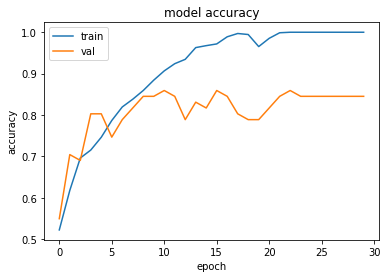

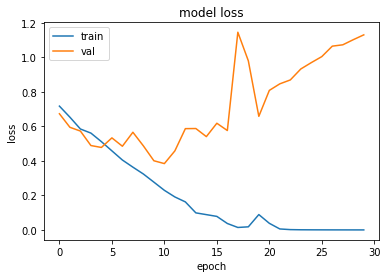

Folder num 47
Genre split [['Blues', 'Classical', 'Hip-Hop', 'Jazz', 'Pop'], ['Country', 'Disco', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

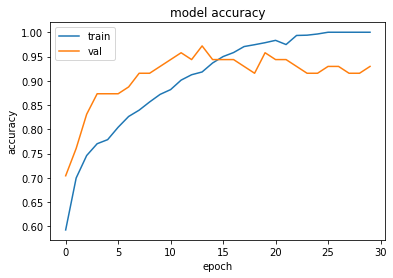

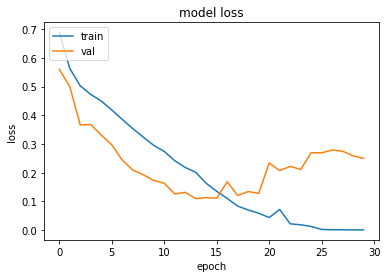

Folder num 48
Genre split [['Classical', 'Country', 'Disco', 'Jazz', 'Pop'], ['Blues', 'Hip-Hop', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_188 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_189 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

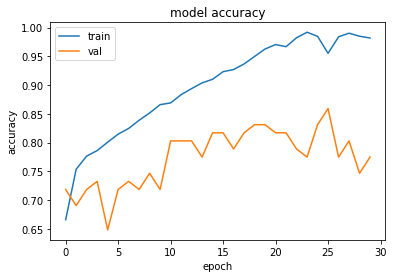

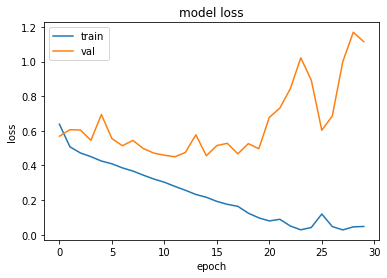

Folder num 49
Genre split [['Blues', 'Country', 'Disco', 'Jazz', 'Pop'], ['Classical', 'Hip-Hop', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

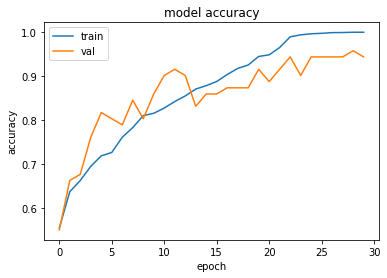

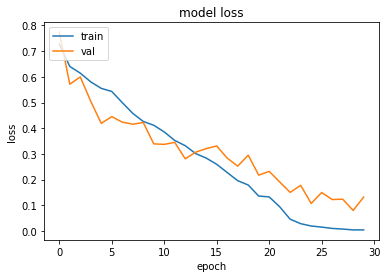

Folder num 50
Genre split [['Blues', 'Classical', 'Disco', 'Jazz', 'Pop'], ['Country', 'Hip-Hop', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_196 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_197 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

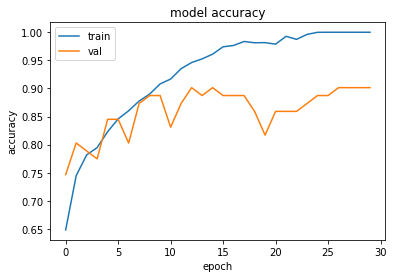

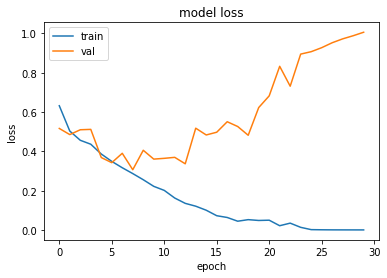

Folder num 51
Genre split [['Blues', 'Classical', 'Country', 'Jazz', 'Pop'], ['Disco', 'Hip-Hop', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_200 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_201 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

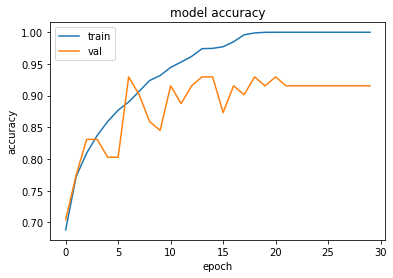

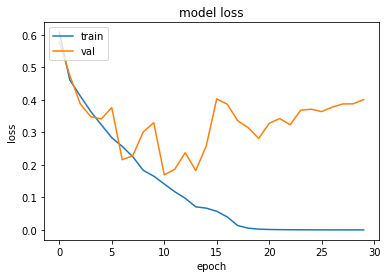

Folder num 52
Genre split [['Classical', 'Country', 'Disco', 'Hip-Hop', 'Pop'], ['Blues', 'Jazz', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_204 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_205 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

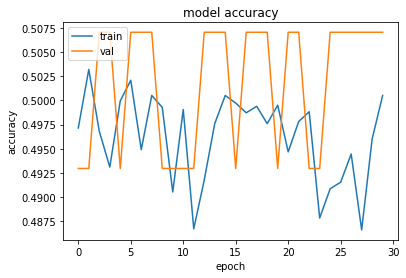

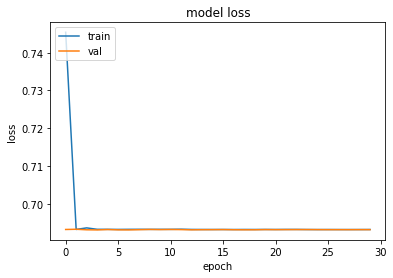

Folder num 53
Genre split [['Blues', 'Country', 'Disco', 'Hip-Hop', 'Pop'], ['Classical', 'Jazz', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_208 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_209 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

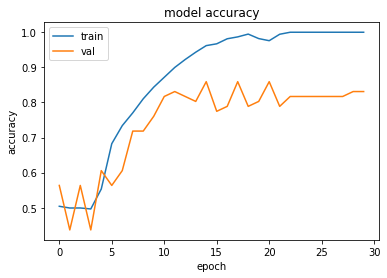

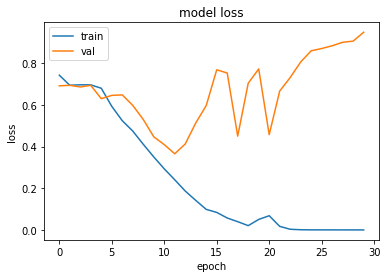

Folder num 54
Genre split [['Blues', 'Classical', 'Disco', 'Hip-Hop', 'Pop'], ['Country', 'Jazz', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_212 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_213 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

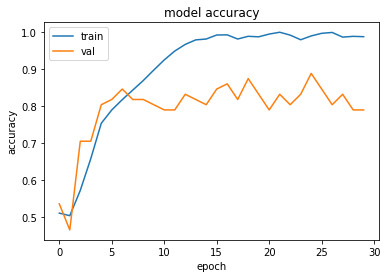

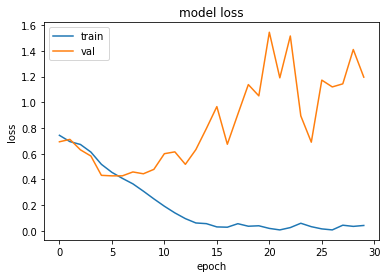

Folder num 55
Genre split [['Blues', 'Classical', 'Country', 'Hip-Hop', 'Pop'], ['Disco', 'Jazz', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_216 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_217 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

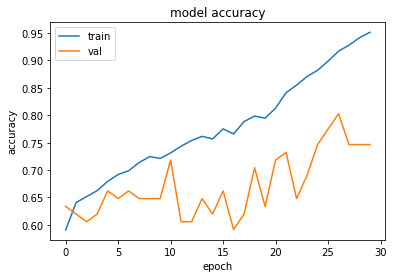

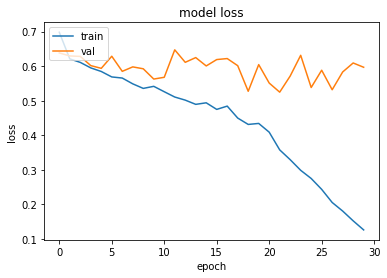

Folder num 56
Genre split [['Blues', 'Classical', 'Country', 'Disco', 'Pop'], ['Hip-Hop', 'Jazz', 'Metal', 'Reggae', 'Rock']]
Building model...
Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_220 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_221 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

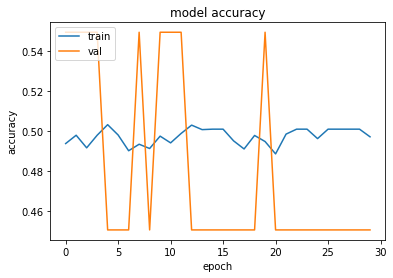

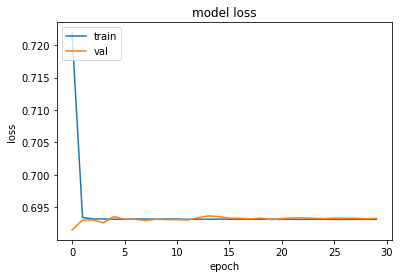

Folder num 57
Genre split [['Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Country', 'Disco', 'Rock']]
Building model...
Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_224 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_225 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

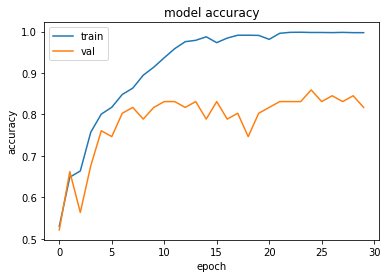

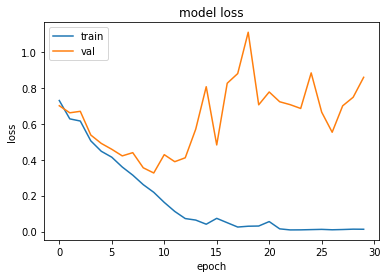

Folder num 58
Genre split [['Disco', 'Jazz', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Country', 'Hip-Hop', 'Rock']]
Building model...
Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_228 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_229 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

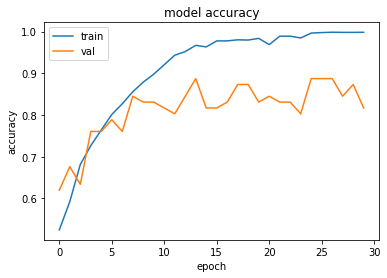

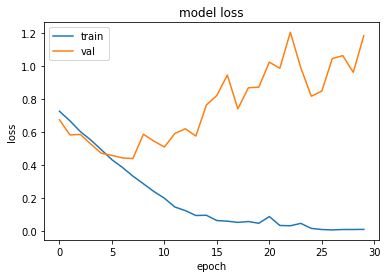

Folder num 59
Genre split [['Country', 'Jazz', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Disco', 'Hip-Hop', 'Rock']]
Building model...
Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_232 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_233 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

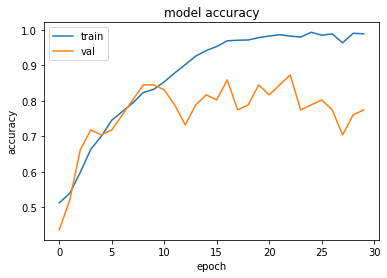

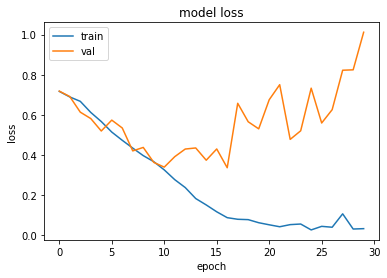

Folder num 60
Genre split [['Classical', 'Jazz', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Country', 'Disco', 'Hip-Hop', 'Rock']]
Building model...
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_236 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_237 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

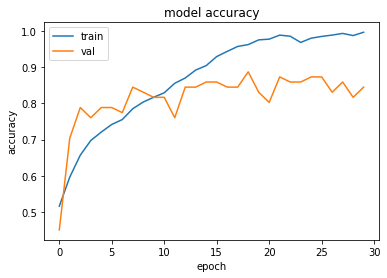

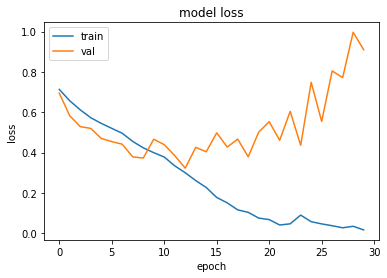

Folder num 61
Genre split [['Blues', 'Jazz', 'Metal', 'Pop', 'Reggae'], ['Classical', 'Country', 'Disco', 'Hip-Hop', 'Rock']]
Building model...
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_240 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_241 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

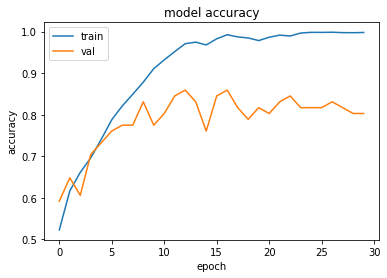

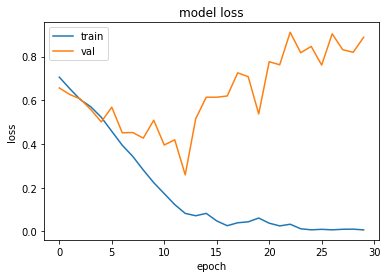

Folder num 62
Genre split [['Disco', 'Hip-Hop', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Country', 'Jazz', 'Rock']]
Building model...
Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_244 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_245 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

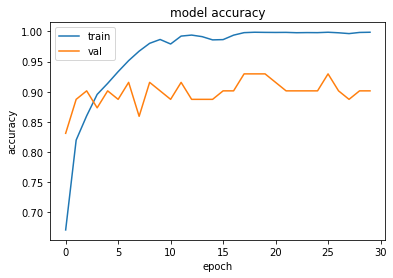

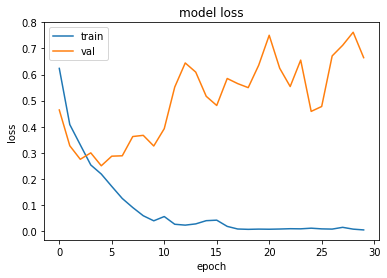

Folder num 63
Genre split [['Country', 'Hip-Hop', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Disco', 'Jazz', 'Rock']]
Building model...
Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_248 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_249 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

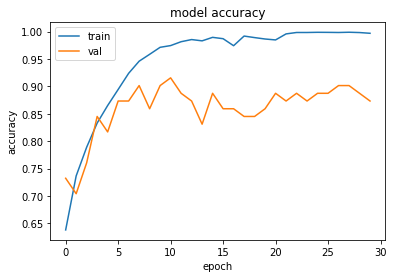

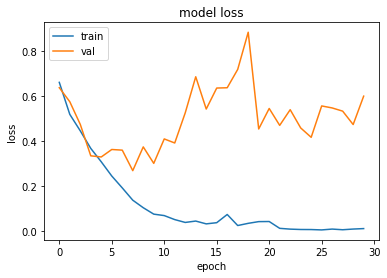

Folder num 64
Genre split [['Classical', 'Hip-Hop', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Country', 'Disco', 'Jazz', 'Rock']]
Building model...
Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_252 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_253 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

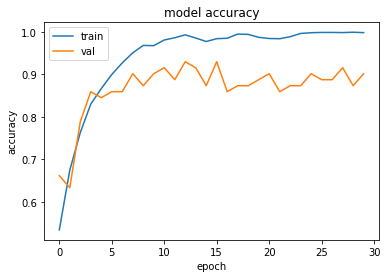

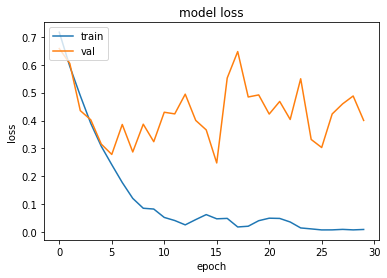

Folder num 65
Genre split [['Blues', 'Hip-Hop', 'Metal', 'Pop', 'Reggae'], ['Classical', 'Country', 'Disco', 'Jazz', 'Rock']]
Building model...
Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_256 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_257 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

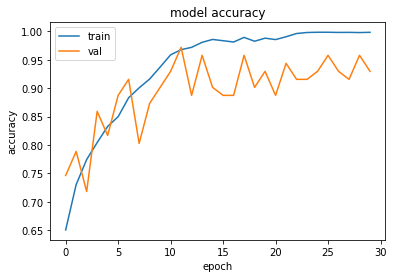

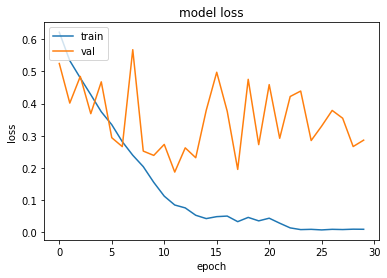

Folder num 66
Genre split [['Country', 'Disco', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Hip-Hop', 'Jazz', 'Rock']]
Building model...
Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_260 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_261 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

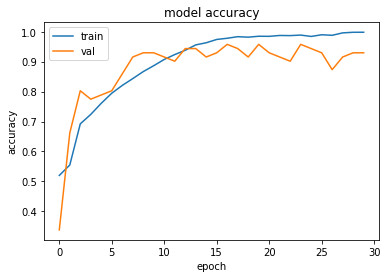

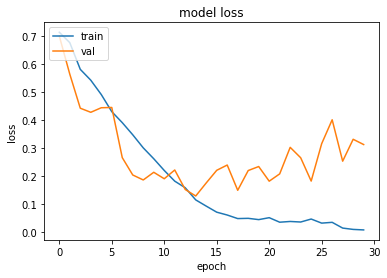

Folder num 67
Genre split [['Classical', 'Disco', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Country', 'Hip-Hop', 'Jazz', 'Rock']]
Building model...
Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_264 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_265 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

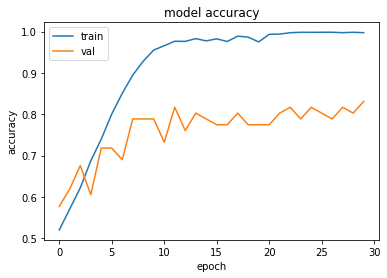

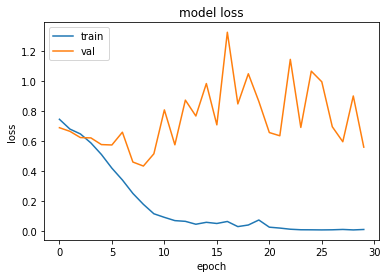

Folder num 68
Genre split [['Blues', 'Disco', 'Metal', 'Pop', 'Reggae'], ['Classical', 'Country', 'Hip-Hop', 'Jazz', 'Rock']]
Building model...
Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_268 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_269 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

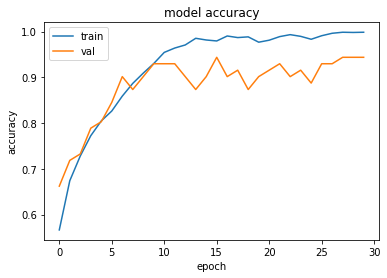

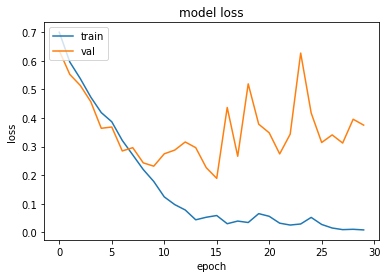

Folder num 69
Genre split [['Classical', 'Country', 'Metal', 'Pop', 'Reggae'], ['Blues', 'Disco', 'Hip-Hop', 'Jazz', 'Rock']]
Building model...
Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_272 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_273 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

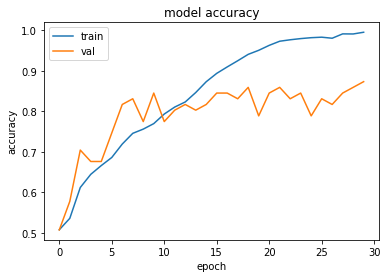

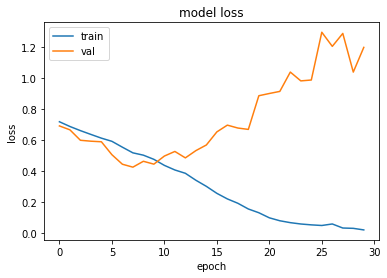

Folder num 70
Genre split [['Blues', 'Country', 'Metal', 'Pop', 'Reggae'], ['Classical', 'Disco', 'Hip-Hop', 'Jazz', 'Rock']]
Building model...
Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_276 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_277 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

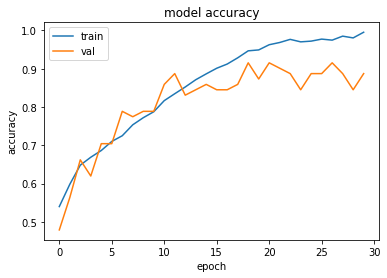

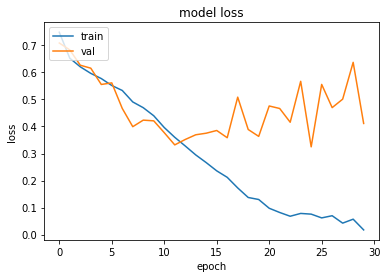

Folder num 71
Genre split [['Blues', 'Classical', 'Metal', 'Pop', 'Reggae'], ['Country', 'Disco', 'Hip-Hop', 'Jazz', 'Rock']]
Building model...
Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_280 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_281 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

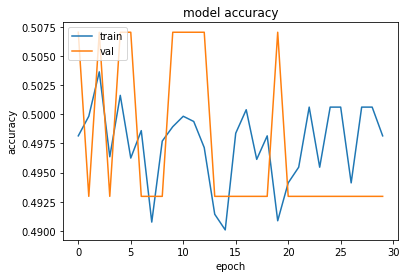

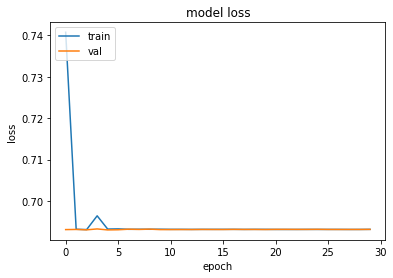

Folder num 72
Genre split [['Disco', 'Hip-Hop', 'Jazz', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Country', 'Metal', 'Rock']]
Building model...
Model: "model_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_284 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_285 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

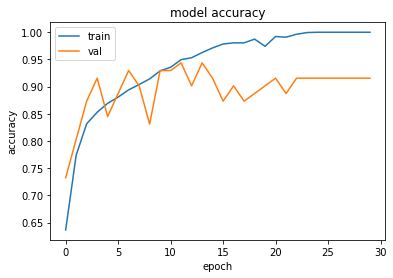

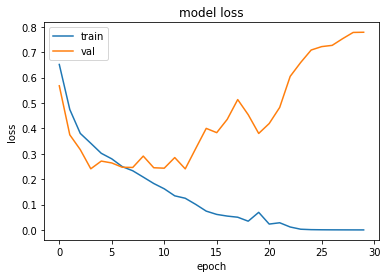

Folder num 73
Genre split [['Country', 'Hip-Hop', 'Jazz', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Disco', 'Metal', 'Rock']]
Building model...
Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_288 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_289 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

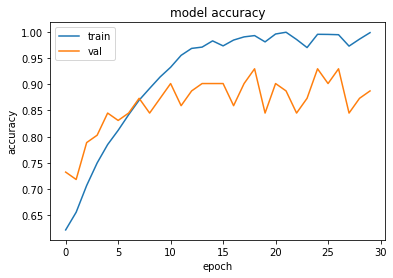

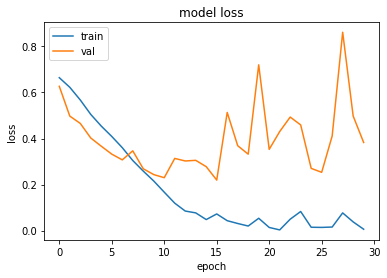

Folder num 74
Genre split [['Classical', 'Hip-Hop', 'Jazz', 'Pop', 'Reggae'], ['Blues', 'Country', 'Disco', 'Metal', 'Rock']]
Building model...
Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_292 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_293 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

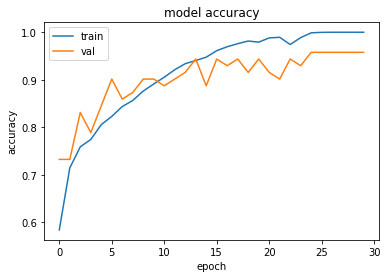

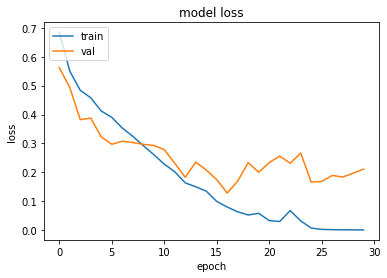

Folder num 75
Genre split [['Blues', 'Hip-Hop', 'Jazz', 'Pop', 'Reggae'], ['Classical', 'Country', 'Disco', 'Metal', 'Rock']]
Building model...
Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_296 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_297 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

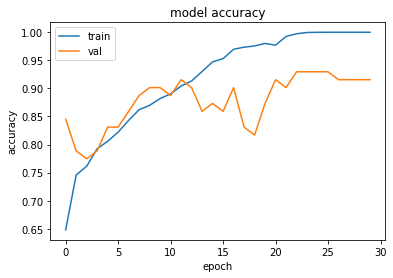

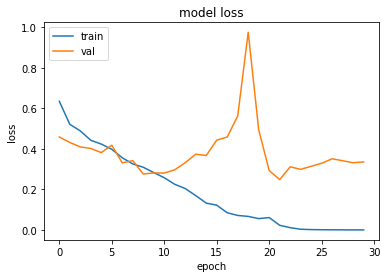

Folder num 76
Genre split [['Country', 'Disco', 'Jazz', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Hip-Hop', 'Metal', 'Rock']]
Building model...
Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_300 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_301 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

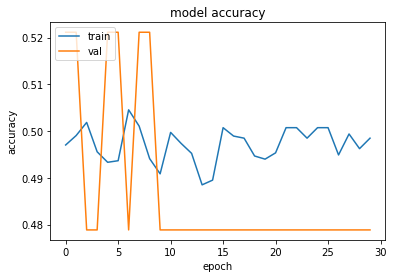

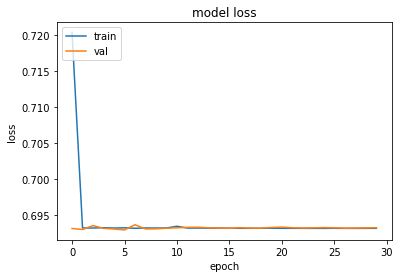

Folder num 77
Genre split [['Classical', 'Disco', 'Jazz', 'Pop', 'Reggae'], ['Blues', 'Country', 'Hip-Hop', 'Metal', 'Rock']]
Building model...
Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_304 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_305 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

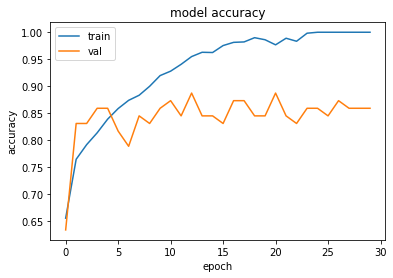

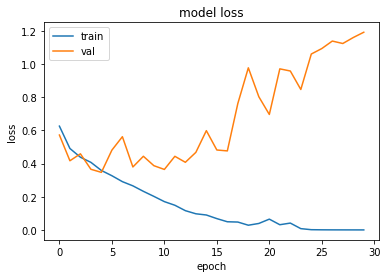

Folder num 78
Genre split [['Blues', 'Disco', 'Jazz', 'Pop', 'Reggae'], ['Classical', 'Country', 'Hip-Hop', 'Metal', 'Rock']]
Building model...
Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_308 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_309 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

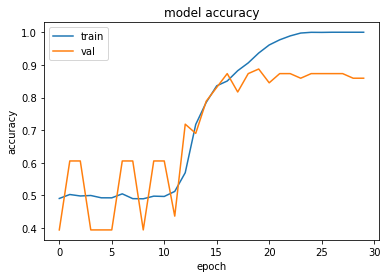

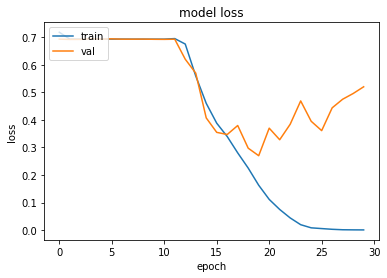

Folder num 79
Genre split [['Classical', 'Country', 'Jazz', 'Pop', 'Reggae'], ['Blues', 'Disco', 'Hip-Hop', 'Metal', 'Rock']]
Building model...
Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_312 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_313 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

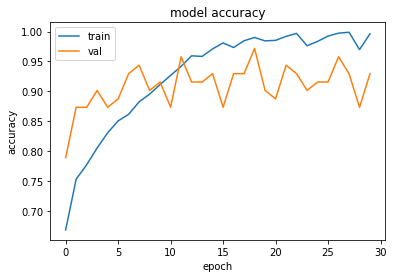

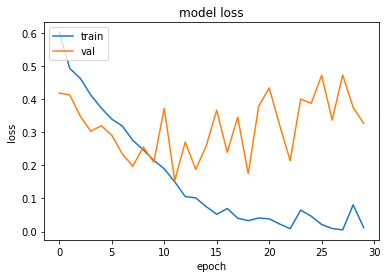

Folder num 80
Genre split [['Blues', 'Country', 'Jazz', 'Pop', 'Reggae'], ['Classical', 'Disco', 'Hip-Hop', 'Metal', 'Rock']]
Building model...
Model: "model_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_316 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_317 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

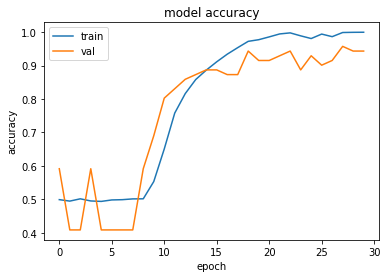

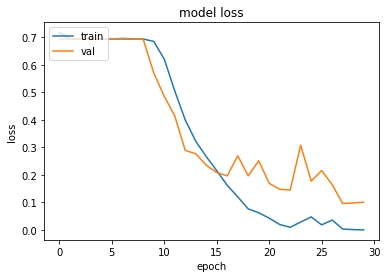

Folder num 81
Genre split [['Blues', 'Classical', 'Jazz', 'Pop', 'Reggae'], ['Country', 'Disco', 'Hip-Hop', 'Metal', 'Rock']]
Building model...
Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_320 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_321 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

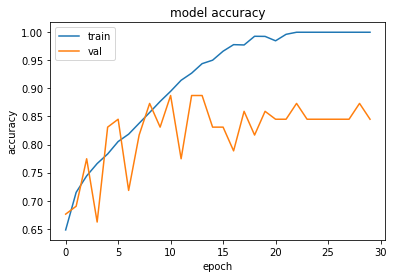

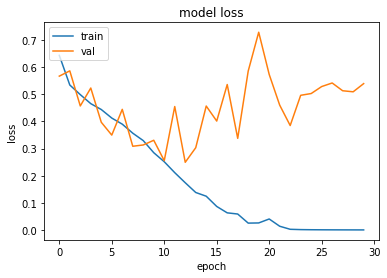

Folder num 82
Genre split [['Country', 'Disco', 'Hip-Hop', 'Pop', 'Reggae'], ['Blues', 'Classical', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_324 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_325 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

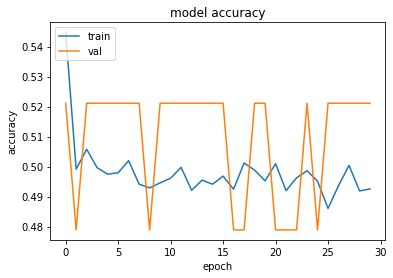

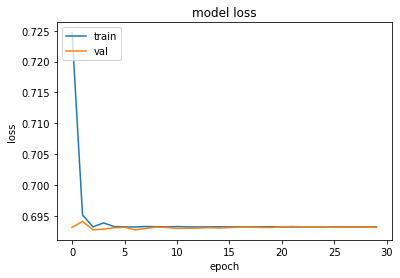

Folder num 83
Genre split [['Classical', 'Disco', 'Hip-Hop', 'Pop', 'Reggae'], ['Blues', 'Country', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_328 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_329 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

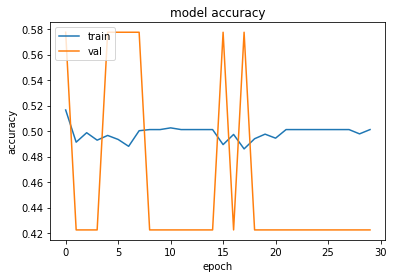

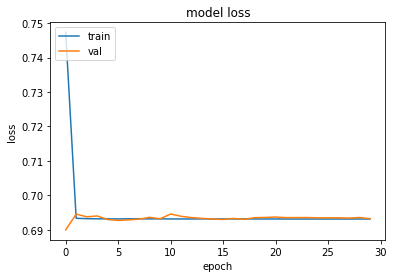

Folder num 84
Genre split [['Blues', 'Disco', 'Hip-Hop', 'Pop', 'Reggae'], ['Classical', 'Country', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_332 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_333 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

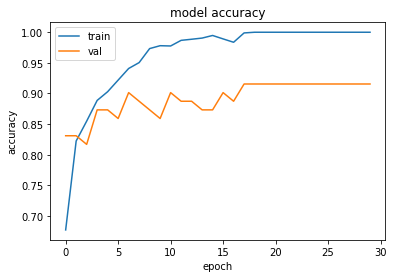

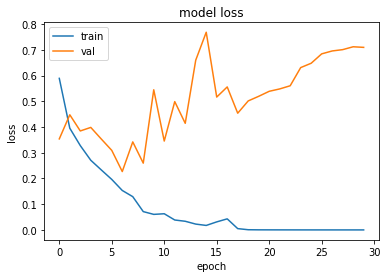

Folder num 85
Genre split [['Classical', 'Country', 'Hip-Hop', 'Pop', 'Reggae'], ['Blues', 'Disco', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_336 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_337 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

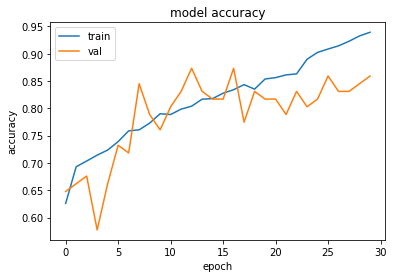

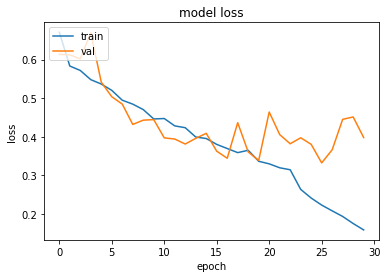

Folder num 86
Genre split [['Blues', 'Country', 'Hip-Hop', 'Pop', 'Reggae'], ['Classical', 'Disco', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_340 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_341 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

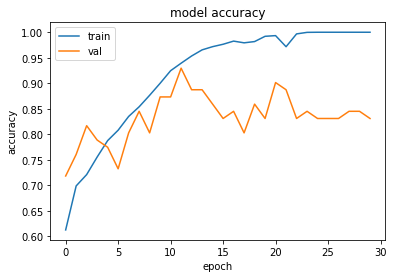

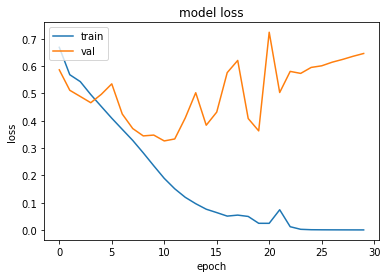

Folder num 87
Genre split [['Blues', 'Classical', 'Hip-Hop', 'Pop', 'Reggae'], ['Country', 'Disco', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_344 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_345 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

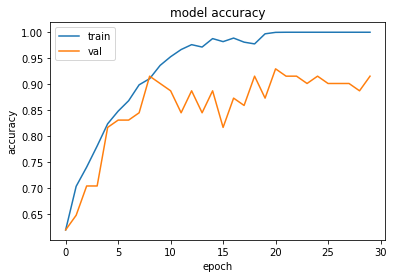

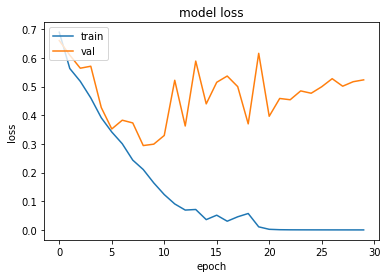

Folder num 88
Genre split [['Classical', 'Country', 'Disco', 'Pop', 'Reggae'], ['Blues', 'Hip-Hop', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_348 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_349 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

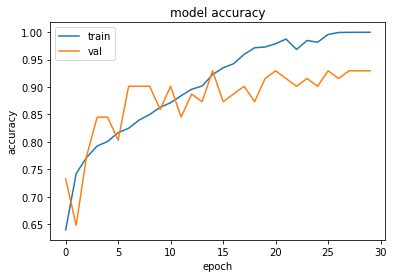

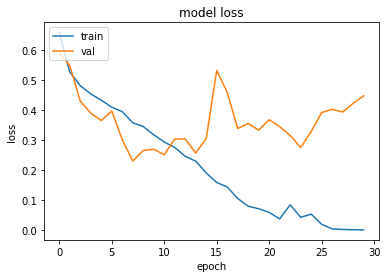

Folder num 89
Genre split [['Blues', 'Country', 'Disco', 'Pop', 'Reggae'], ['Classical', 'Hip-Hop', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_352 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_353 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

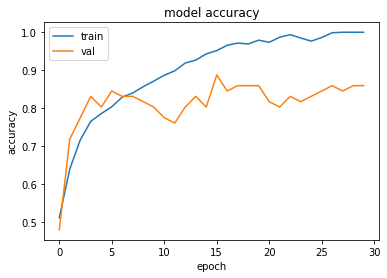

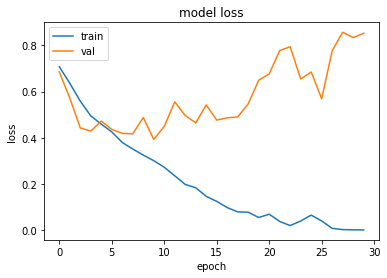

Folder num 90
Genre split [['Blues', 'Classical', 'Disco', 'Pop', 'Reggae'], ['Country', 'Hip-Hop', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_356 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_357 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

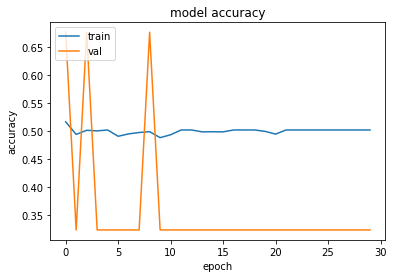

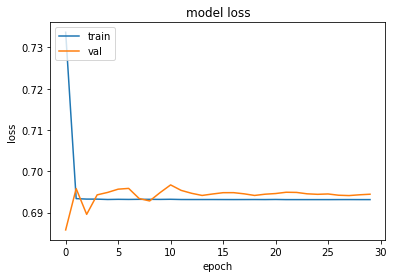

Folder num 91
Genre split [['Blues', 'Classical', 'Country', 'Pop', 'Reggae'], ['Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Rock']]
Building model...
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_360 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_361 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

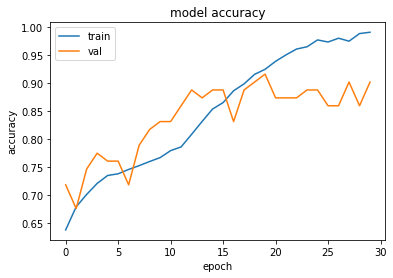

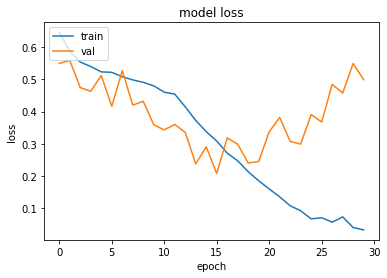

Folder num 92
Genre split [['Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Reggae'], ['Blues', 'Classical', 'Country', 'Pop', 'Rock']]
Building model...
Model: "model_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_364 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_365 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

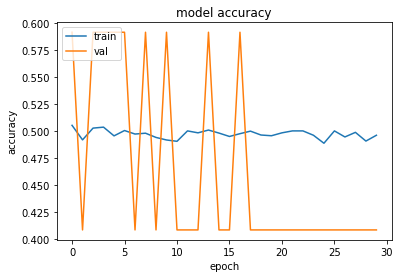

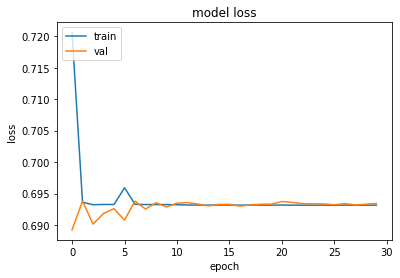

Folder num 93
Genre split [['Country', 'Hip-Hop', 'Jazz', 'Metal', 'Reggae'], ['Blues', 'Classical', 'Disco', 'Pop', 'Rock']]
Building model...
Model: "model_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_368 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_369 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

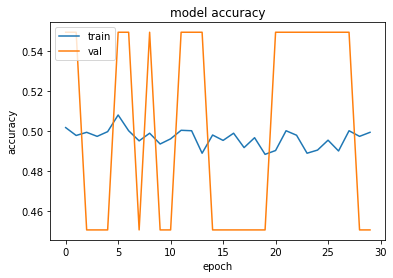

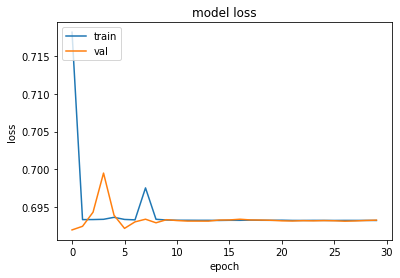

Folder num 94
Genre split [['Classical', 'Hip-Hop', 'Jazz', 'Metal', 'Reggae'], ['Blues', 'Country', 'Disco', 'Pop', 'Rock']]
Building model...
Model: "model_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_372 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_373 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

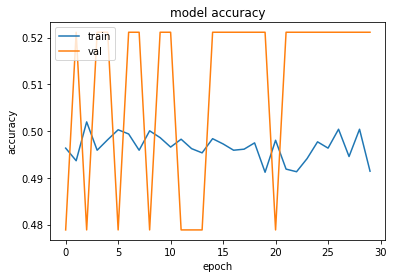

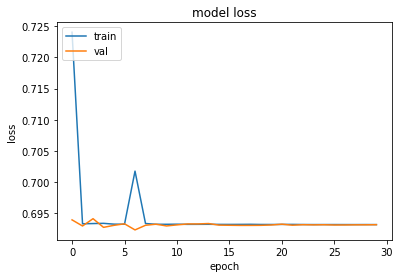

Folder num 95
Genre split [['Blues', 'Hip-Hop', 'Jazz', 'Metal', 'Reggae'], ['Classical', 'Country', 'Disco', 'Pop', 'Rock']]
Building model...
Model: "model_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_376 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_377 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

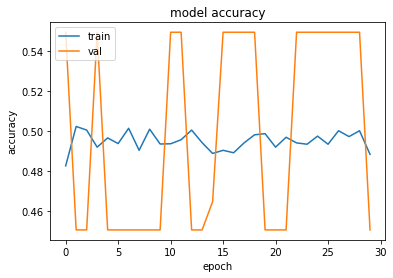

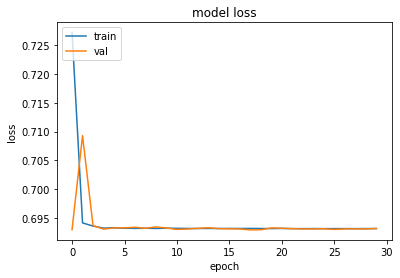

Folder num 96
Genre split [['Country', 'Disco', 'Jazz', 'Metal', 'Reggae'], ['Blues', 'Classical', 'Hip-Hop', 'Pop', 'Rock']]
Building model...
Model: "model_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_380 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_381 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

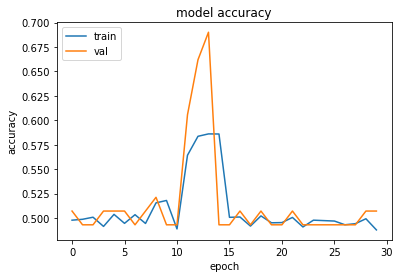

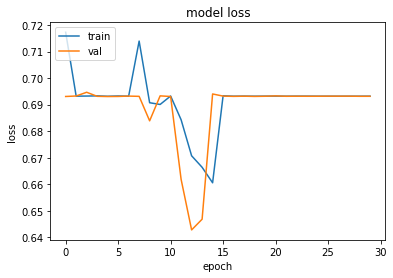

Folder num 97
Genre split [['Classical', 'Disco', 'Jazz', 'Metal', 'Reggae'], ['Blues', 'Country', 'Hip-Hop', 'Pop', 'Rock']]
Building model...
Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_384 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_385 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

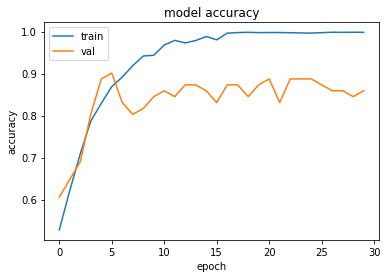

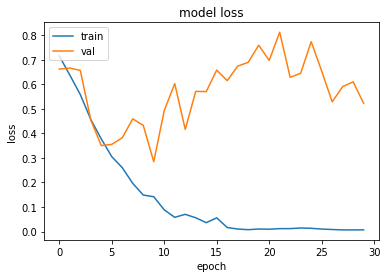

Folder num 98
Genre split [['Blues', 'Disco', 'Jazz', 'Metal', 'Reggae'], ['Classical', 'Country', 'Hip-Hop', 'Pop', 'Rock']]
Building model...
Model: "model_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_388 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_389 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

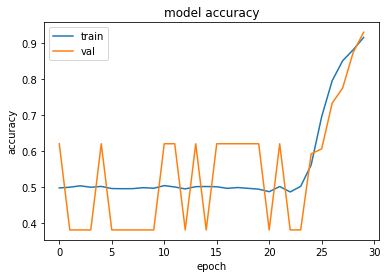

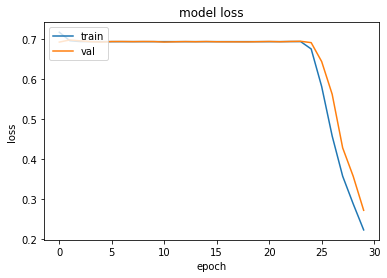

Folder num 99
Genre split [['Classical', 'Country', 'Jazz', 'Metal', 'Reggae'], ['Blues', 'Disco', 'Hip-Hop', 'Pop', 'Rock']]
Building model...
Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_392 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_393 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 12

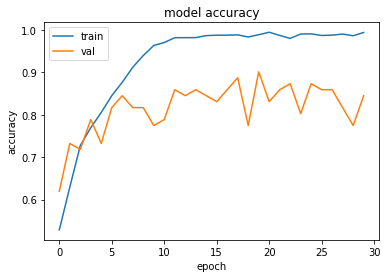

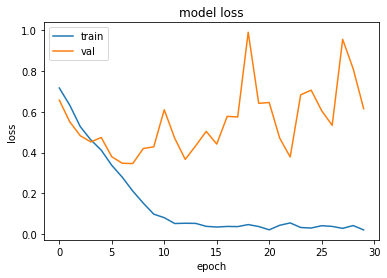

Folder num 100
Genre split [['Blues', 'Country', 'Jazz', 'Metal', 'Reggae'], ['Classical', 'Disco', 'Hip-Hop', 'Pop', 'Rock']]
Building model...
Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_396 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_397 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 1

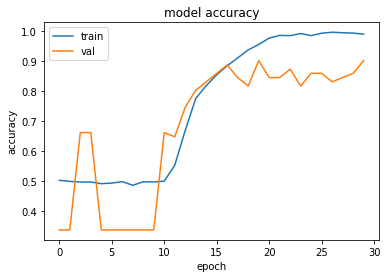

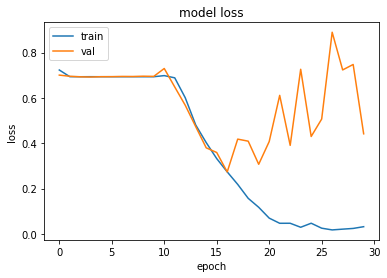

Folder num 101
Genre split [['Blues', 'Classical', 'Jazz', 'Metal', 'Reggae'], ['Country', 'Disco', 'Hip-Hop', 'Pop', 'Rock']]
Building model...
Model: "model_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_400 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_401 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

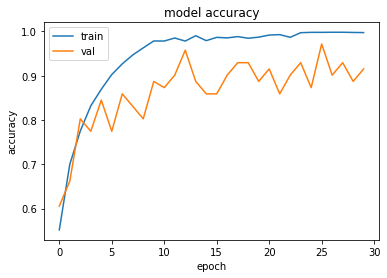

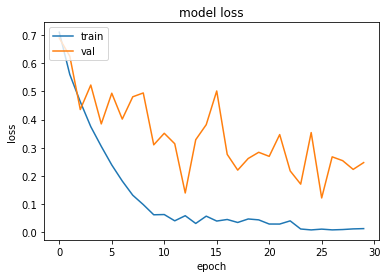

Folder num 102
Genre split [['Country', 'Disco', 'Hip-Hop', 'Metal', 'Reggae'], ['Blues', 'Classical', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_404 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_405 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

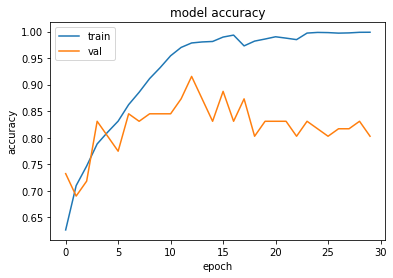

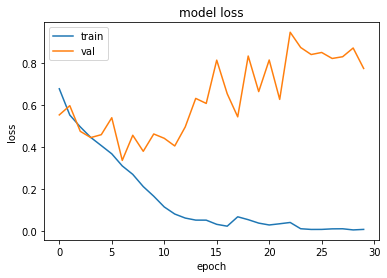

Folder num 103
Genre split [['Classical', 'Disco', 'Hip-Hop', 'Metal', 'Reggae'], ['Blues', 'Country', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_408 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_409 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

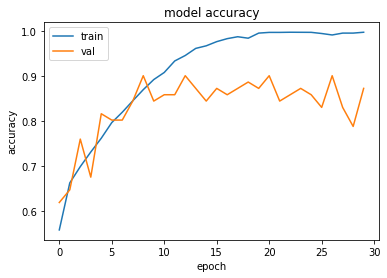

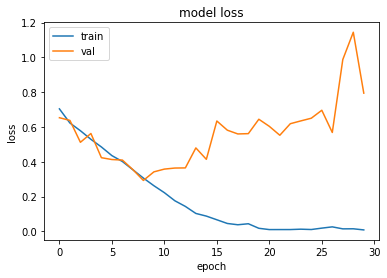

Folder num 104
Genre split [['Blues', 'Disco', 'Hip-Hop', 'Metal', 'Reggae'], ['Classical', 'Country', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_412 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_413 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

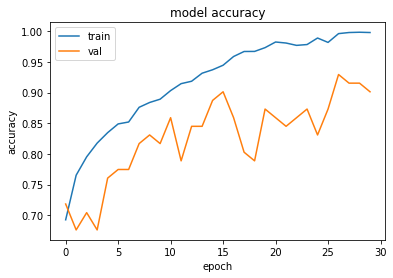

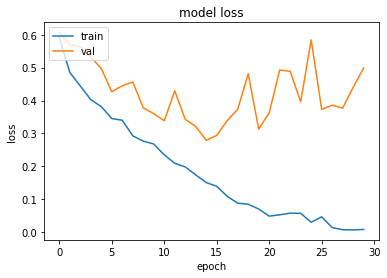

Folder num 105
Genre split [['Classical', 'Country', 'Hip-Hop', 'Metal', 'Reggae'], ['Blues', 'Disco', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_416 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_417 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

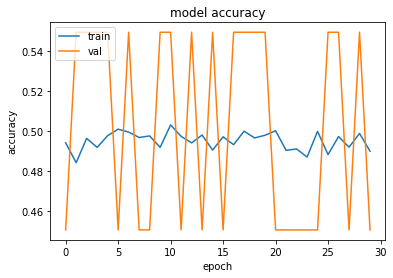

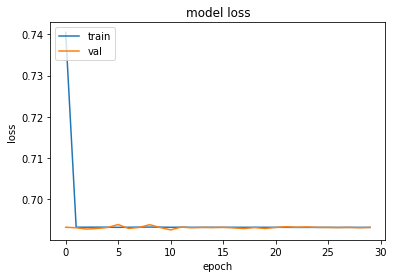

Folder num 106
Genre split [['Blues', 'Country', 'Hip-Hop', 'Metal', 'Reggae'], ['Classical', 'Disco', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_420 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_421 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

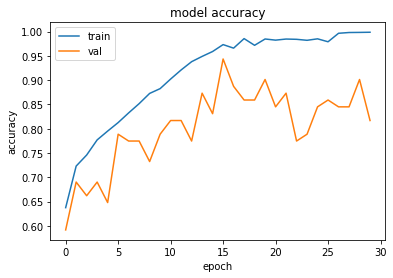

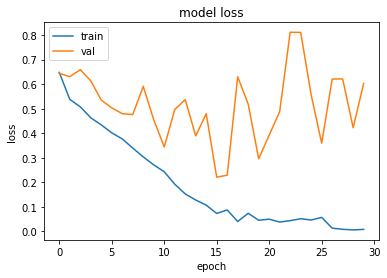

Folder num 107
Genre split [['Blues', 'Classical', 'Hip-Hop', 'Metal', 'Reggae'], ['Country', 'Disco', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_424 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_425 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

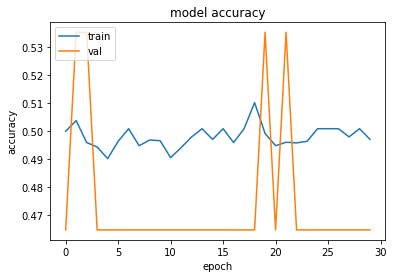

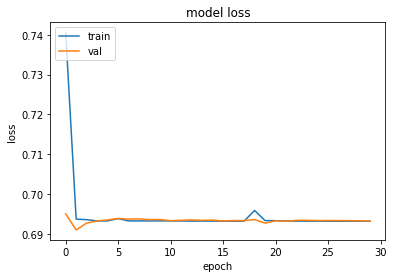

Folder num 108
Genre split [['Classical', 'Country', 'Disco', 'Metal', 'Reggae'], ['Blues', 'Hip-Hop', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_428 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_429 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

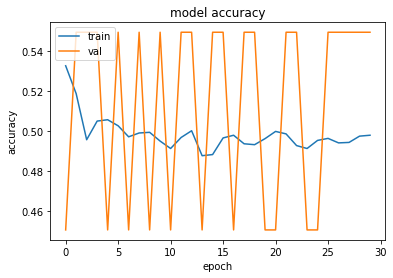

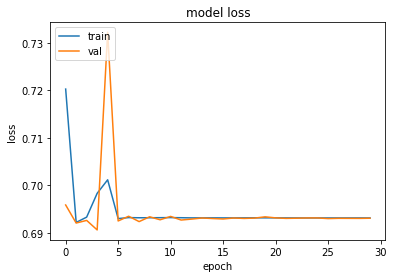

Folder num 109
Genre split [['Blues', 'Country', 'Disco', 'Metal', 'Reggae'], ['Classical', 'Hip-Hop', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_432 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_433 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

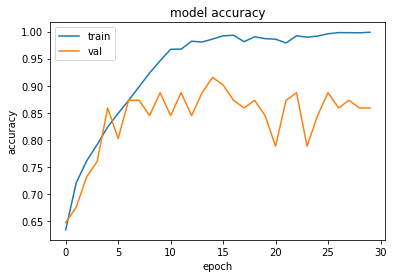

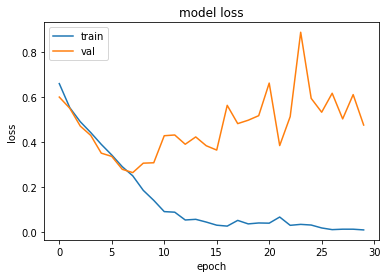

Folder num 110
Genre split [['Blues', 'Classical', 'Disco', 'Metal', 'Reggae'], ['Country', 'Hip-Hop', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_436 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_437 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

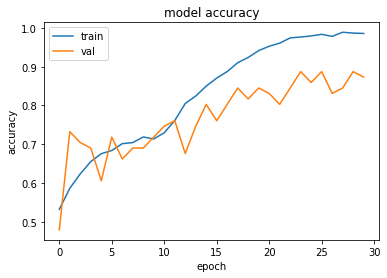

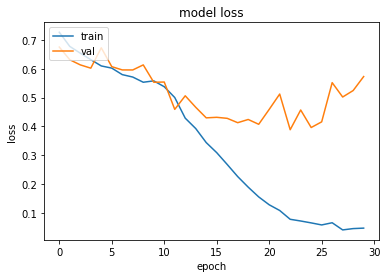

Folder num 111
Genre split [['Blues', 'Classical', 'Country', 'Metal', 'Reggae'], ['Disco', 'Hip-Hop', 'Jazz', 'Pop', 'Rock']]
Building model...
Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_440 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_441 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

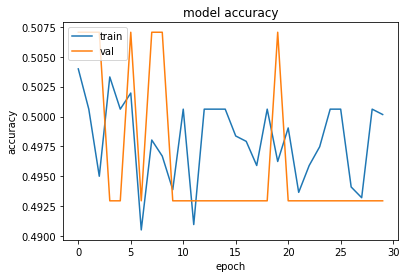

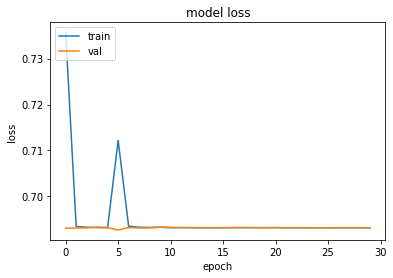

Folder num 112
Genre split [['Country', 'Disco', 'Hip-Hop', 'Jazz', 'Reggae'], ['Blues', 'Classical', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_444 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_445 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

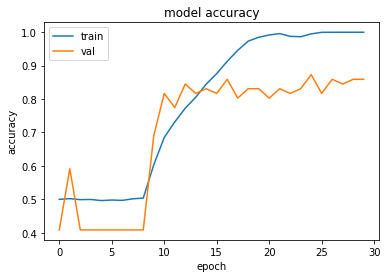

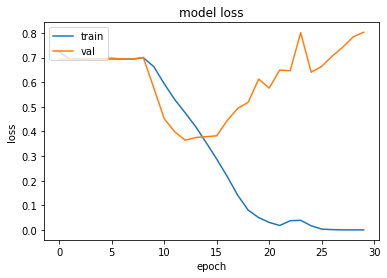

Folder num 113
Genre split [['Classical', 'Disco', 'Hip-Hop', 'Jazz', 'Reggae'], ['Blues', 'Country', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_448 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_449 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

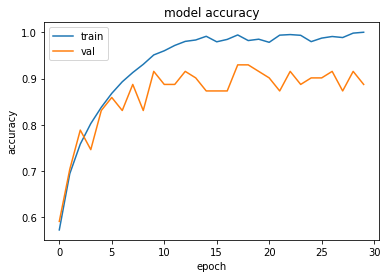

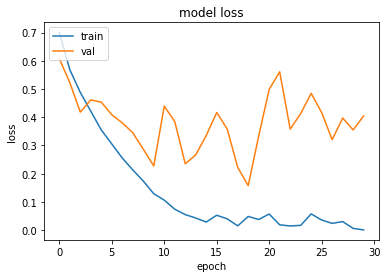

Folder num 114
Genre split [['Blues', 'Disco', 'Hip-Hop', 'Jazz', 'Reggae'], ['Classical', 'Country', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_452 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_453 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

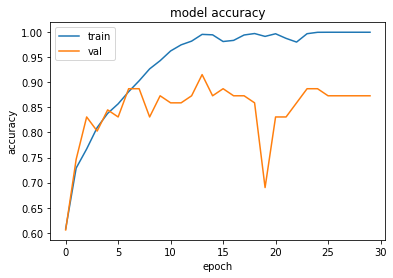

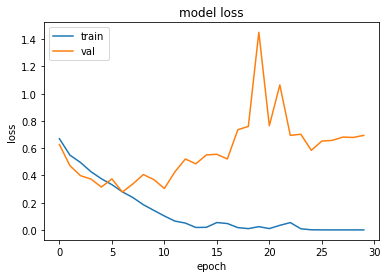

Folder num 115
Genre split [['Classical', 'Country', 'Hip-Hop', 'Jazz', 'Reggae'], ['Blues', 'Disco', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_456 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_457 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

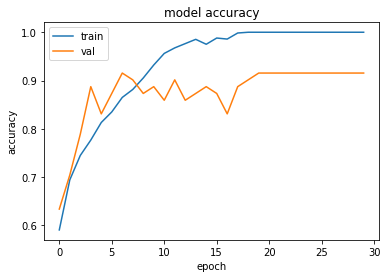

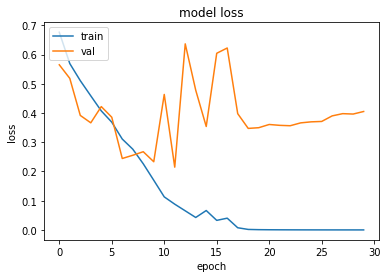

Folder num 116
Genre split [['Blues', 'Country', 'Hip-Hop', 'Jazz', 'Reggae'], ['Classical', 'Disco', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_460 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_461 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

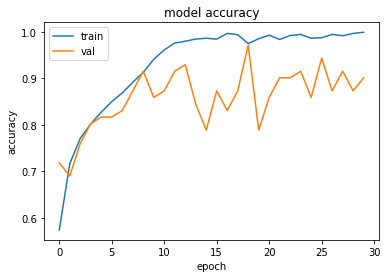

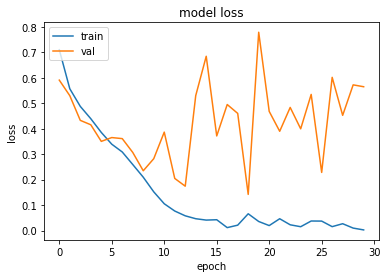

Folder num 117
Genre split [['Blues', 'Classical', 'Hip-Hop', 'Jazz', 'Reggae'], ['Country', 'Disco', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_464 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_465 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

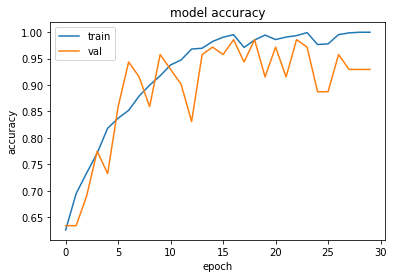

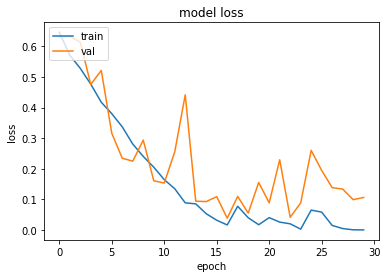

Folder num 118
Genre split [['Classical', 'Country', 'Disco', 'Jazz', 'Reggae'], ['Blues', 'Hip-Hop', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_468 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_469 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

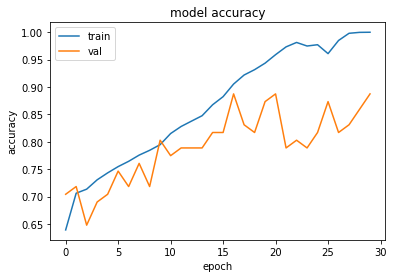

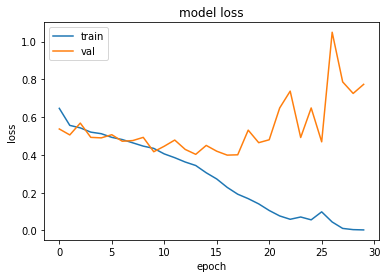

Folder num 119
Genre split [['Blues', 'Country', 'Disco', 'Jazz', 'Reggae'], ['Classical', 'Hip-Hop', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_472 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_473 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

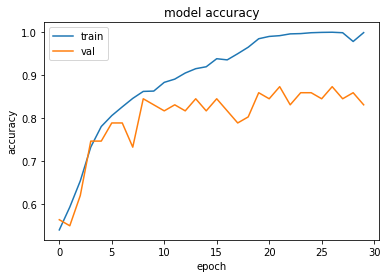

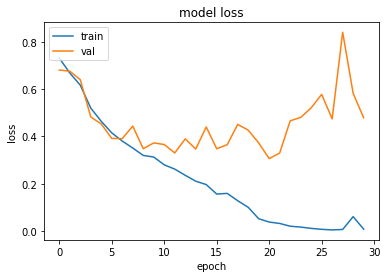

Folder num 120
Genre split [['Blues', 'Classical', 'Disco', 'Jazz', 'Reggae'], ['Country', 'Hip-Hop', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_476 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_477 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

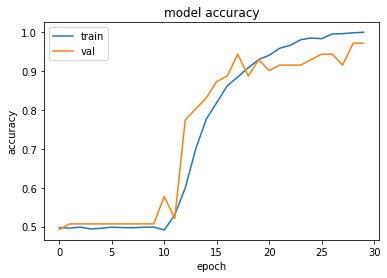

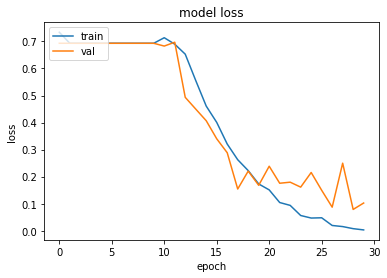

Folder num 121
Genre split [['Blues', 'Classical', 'Country', 'Jazz', 'Reggae'], ['Disco', 'Hip-Hop', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_480 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_481 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

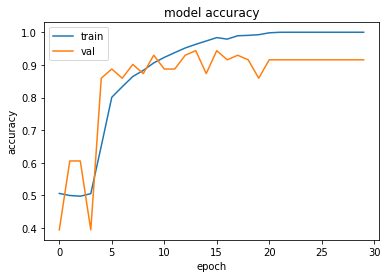

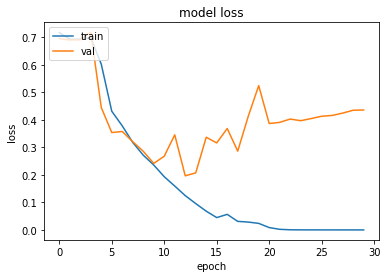

Folder num 122
Genre split [['Classical', 'Country', 'Disco', 'Hip-Hop', 'Reggae'], ['Blues', 'Jazz', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_484 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_485 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

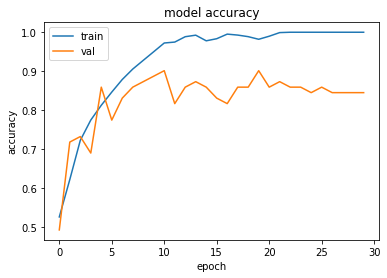

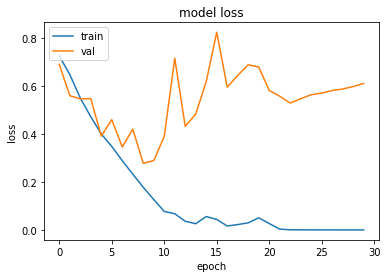

Folder num 123
Genre split [['Blues', 'Country', 'Disco', 'Hip-Hop', 'Reggae'], ['Classical', 'Jazz', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_488 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_489 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

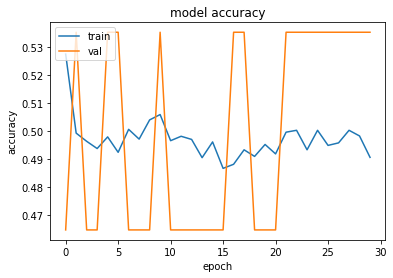

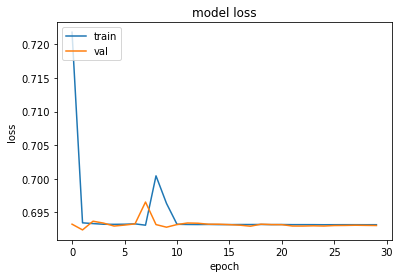

Folder num 124
Genre split [['Blues', 'Classical', 'Disco', 'Hip-Hop', 'Reggae'], ['Country', 'Jazz', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_492 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_493 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

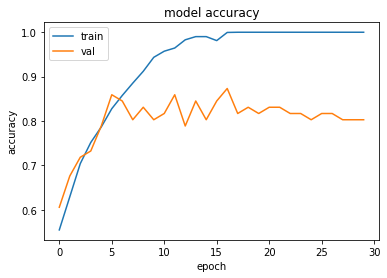

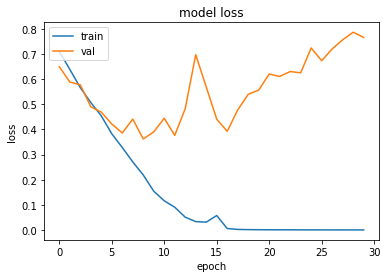

Folder num 125
Genre split [['Blues', 'Classical', 'Country', 'Hip-Hop', 'Reggae'], ['Disco', 'Jazz', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_496 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_497 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

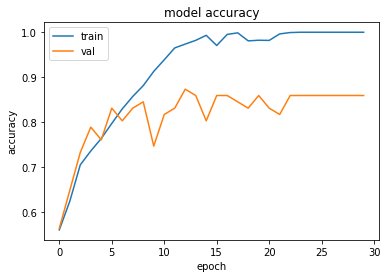

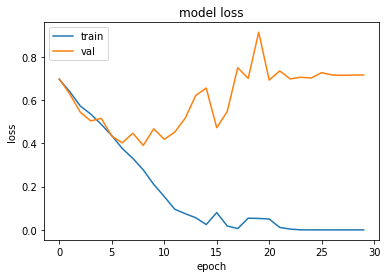

Folder num 126
Genre split [['Blues', 'Classical', 'Country', 'Disco', 'Reggae'], ['Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Rock']]
Building model...
Model: "model_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_500 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_501 (MaxPoolin (None, 30, 30, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 

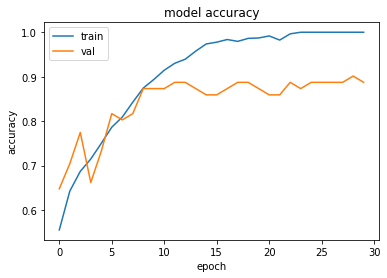

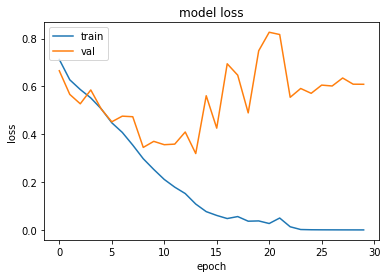

In [12]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

genre_splits, num_splits = create_split(list(dict_genres.values()))
print("Num splits {}".format(num_splits))

if num_splits > 8:
    n_splits = num_splits
else:
    n_splits = 8

kfold = KFold(n_splits, shuffle=True)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    split = genre_splits[fold_no - 1]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)
    
    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break